In [1]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import imageio
from PIL import Image, ImageDraw, ImageFont


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [2]:
class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """ 
    @abstractmethod
    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, ...)
            - labels: shape (batch_size, label_dim)
        """
        pass

class IsotropicGaussian(nn.Module, Sampleable):
    """
    Sampleable wrapper around torch.randn
    """
    def __init__(self, shape: List[int], std: float = 1.0):
        """
        shape: shape of sampled data
        """
        super().__init__()
        self.shape = shape
        self.std = std
        #self.dummy = nn.Buffer(torch.zeros(1)) # Will automatically be moved when self.to(...) is called...
        self.register_buffer("dummy", torch.zeros(1))
        
    def sample(self, num_samples) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.std * torch.randn(num_samples, *self.shape).to(self.dummy.device), None

In [3]:
class ConditionalProbabilityPath(nn.Module, ABC):
    """
    Abstract base class for conditional probability paths
    """
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x), (num_samples, c, h, w)
        """
        num_samples = t.shape[0]
        # Sample conditioning variable z ~ p(z)
        z, _ = self.sample_conditioning_variable(num_samples) # (num_samples, c, h, w)
        # Sample conditional probability path x ~ p_t(x|z)
        x = self.sample_conditional_path(z, t) # (num_samples, c, h, w)
        return x

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Samples the conditioning variable z and label y
        Args:
            - num_samples: the number of samples
        Returns:
            - z: (num_samples, c, h, w)
            - y: (num_samples, label_dim)
        """
        pass
    
    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, c, h, w)
        """
        pass
        
    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """ 
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """ 
        pass

In [71]:
class Alpha(ABC):
    def __init__(self):
        # Check alpha_t(0) = 0
        print("alpha_0=",self(torch.zeros(1,1,1,1)))
        print("alpha_1=",self(torch.ones(1,1,1,1)))
        #assert torch.allclose(
        #    self(torch.zeros(1,1,1,1)), torch.zeros(1,1,1,1)
        #)
        # Check alpha_1 = 1
        #assert torch.allclose(
        #    self(torch.ones(1,1,1,1)), torch.ones(1,1,1,1)
        #)
        
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 0.0, self(1.0) = 1.0.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - alpha_t (num_samples, 1, 1, 1)
        """ 
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """ 
        t = t.unsqueeze(1)
        dt = vmap(jacrev(self))(t)
        return dt.view(-1, 1, 1, 1)
    
class Beta(ABC):
    def __init__(self):
        # Check beta_0 = 1
        print("beta_0=",self(torch.zeros(1,1,1,1)))
        print("beta_1=",self(torch.ones(1,1,1,1)))
        #assert torch.allclose(
        #    self(torch.zeros(1,1,1,1)), torch.ones(1,1,1,1)
        #)
        # Check beta_1 = 0
        #assert torch.allclose(
        #    self(torch.ones(1,1,1,1)), torch.zeros(1,1,1,1)
        #)
        
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 1.0, self(1.0) = 0.0.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - beta_t (num_samples, 1, 1, 1)
        """ 
        pass 

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt beta_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt beta_t (num_samples, 1, 1, 1)
        """ 
        t = t.unsqueeze(1)
        dt = vmap(jacrev(self))(t)
        return dt.view(-1, 1, 1, 1)

class LinearAlpha(Alpha):
    """
    Implements alpha_t = t
    """
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - alpha_t (num_samples, 1, 1, 1)
        """ 
        return t
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """ 
        return torch.ones_like(t)

class LinearBeta(Beta):
    """
    Implements beta_t = 1-t
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """ 
        return 1-t
        
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """ 
        return - torch.ones_like(t)

class CosineAlpha(Alpha):
    """
    Implements alpha_t = t
    """
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - alpha_t (num_samples, 1, 1, 1)
        """ 
        return torch.sin(0.5*math.pi*t)
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """ 
        return 0.5*math.pi*torch.cos(0.5*math.pi*t)
        
class SinusBeta(Beta):
    """
    Implements beta_t = 1-t
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """ 
        return torch.cos(0.5*math.pi*t)
        
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """ 
        return -0.5*math.pi*torch.sin(0.5*math.pi*t)
    
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, p_simple_shape: List[int], alpha: Alpha, beta: Beta):
        p_simple = IsotropicGaussian(shape = p_simple_shape, std = 1.0)
        super().__init__(p_simple, p_data)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z and label y
        Args:
            - num_samples: the number of samples
        Returns:
            - z: (num_samples, c, h, w)
            - y: (num_samples, label_dim)
        """
        return self.p_data.sample(num_samples)
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, c, h, w)
        """
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)
        
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """ 
        alpha_t = self.alpha(t) # (num_samples, 1, 1, 1)
        beta_t = self.beta(t) # (num_samples, 1, 1, 1)
        dt_alpha_t = self.alpha.dt(t) # (num_samples, 1, 1, 1)
        dt_beta_t = self.beta.dt(t) # (num_samples, 1, 1, 1)

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """ 
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

    def conditional_score_no_beta(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """ 
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x), beta_t ** 2

In [72]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1)
        Returns:
            - drift_coefficient: shape (bs, c, h, w)
        """
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
        Returns:
            - drift_coefficient: shape (bs, c, h, w)
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
        Returns:
            - diffusion_coefficient: shape (bs, c, h, w)
        """
        pass

In [73]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
            - dt: time, shape (bs, 1, 1, 1)
        Returns:
            - nxt: state at time t + dt (bs, c, h, w)
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - x_final: final state at time ts[-1], shape (bs, c, h, w)
        """
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, nts, c, h, w)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.ode.drift_coefficient(xt,t, **kwargs) * h

class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.sde.drift_coefficient(xt,t, **kwargs) * h + self.sde.diffusion_coefficient(xt,t, **kwargs) * torch.sqrt(h) * torch.randn_like(xt)

def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )

In [74]:
MiB = 1024 ** 2

def model_size_b(model: nn.Module) -> int:
    """
    Returns model size in bytes. Based on https://discuss.pytorch.org/t/finding-model-size/130275/2
    Args:
    - model: self-explanatory
    Returns:
    - size: model size in bytes
    """
    size = 0
    for param in model.parameters():
        size += param.nelement() * param.element_size()
    for buf in model.buffers():
        size += buf.nelement() * buf.element_size()
    return size

class Trainer(ABC):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
        # Report model size
        size_b = model_size_b(self.model)
        print(f'Training model with size: {size_b / MiB:.3f} MiB')
        
        # Start
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item():.3f}')

        # Finish
        self.model.eval()

# Playing with sudoku (baseline diffusion)

Some useful functions.

In [75]:
def show_sudoku(cells):
    """
    cells: iterable of 81 ints (0–9). 0/None are shown as blanks.
    """
    if len(cells) != 81:
        raise ValueError("Need exactly 81 values.")
    sym = lambda v: "." if (v is None or v == 0) else str(v)
    row = lambda r: " ".join(sym(x) for x in r)
    line = "+-------+-------+-------+"
    out = [line]
    for i in range(9):
        r = cells[i*9:(i+1)*9]
        out.append("| " + " | ".join([row(r[0:3]), row(r[3:6]), row(r[6:9])]) + " |")
        if i % 3 == 2: out.append(line)
    print("\n".join(out))

def valid_sudoku81(s):
    if len(s) != 81:
        return False
    s = [int(x) for x in s]
    ok = set(range(1, 10))
    return all(
        set(s[i*9:(i+1)*9]) == ok and               # rows
        set(s[i::9]) == ok and                      # cols
        set(s[(i//3)*27 + (i%3)*3 + r*9 + c]        # 3x3 boxes
            for r in range(3) for c in range(3)) == ok
        for i in range(9)
    )

def sudoku81_report(s):
    if len(s) != 81:
        return "invalid length (need 81)"
    s = [int(x) for x in s]
    ok = set(range(1, 10))

    rows = sum(set(s[i*9:(i+1)*9]) == ok for i in range(9))
    cols = sum(set(s[i::9]) == ok for i in range(9))
    blks = sum(
        set(s[(i//3)*27 + (i%3)*3 + r*9 + c] for r in range(3) for c in range(3)) == ok
        for i in range(9)
    )
    return rows, cols, blks

def print_sudoku_report(rows, cols, blks):
    return (f"number of correct rows: {rows}/9\n"
            f"number of correct columns: {cols}/9\n"
            f"number of correct blocks: {blks}/9")

def draw_one_sudoku(ax, cells, gt=None, title=None):
    cells = np.asarray(cells).reshape(9, 9)
    if gt is not None:
        gt = np.asarray(gt).reshape(9, 9)

    ax.set_xlim(0, 9)
    ax.set_ylim(9, 0)
    ax.set_aspect("equal")
    ax.axis("off")

    # grid
    for i in range(10):
        lw = 2.2 if i % 3 == 0 else 0.8
        ax.plot([0, 9], [i, i], linewidth=lw, color="black")
        ax.plot([i, i], [0, 9], linewidth=lw, color="black")

    # digits
    for r in range(9):
        for c in range(9):
            v = int(cells[r, c])
            if v == 0:
                continue

            color = "black"
            if gt is not None:
                color = "green" if v == int(gt[r, c]) else "red"

            ax.text(c + 0.5, r + 0.62, str(v),
                    ha="center", va="center",
                    fontsize=14, color=color)

    if title:
        ax.set_title(title, fontsize=10)

def draw_sudoku_path(cells_history, gt=None, titles=None, figsize_per=2.2, dpi=150):
    T = len(cells_history)
    fig, axes = plt.subplots(1, T, figsize=(figsize_per * T, figsize_per), dpi=dpi)

    # if T==1, axes is not a list
    if T == 1:
        axes = [axes]

    for i, (ax, cells) in enumerate(zip(axes, cells_history)):
        title = titles[i] if titles is not None else None
        draw_one_sudoku(ax, cells, gt=gt, title=title)

    plt.tight_layout()
    plt.show()

In [76]:
base_path = "data/sudoku-extreme-1k-aug-1000/"
train_inputs = np.load(f"{base_path}/train/all__inputs.npy")-1
train_outputs = np.load(f"{base_path}/train/all__labels.npy")-1
test_inputs = np.load(f"{base_path}/test/all__inputs.npy")-1
test_outputs = np.load(f"{base_path}/test/all__labels.npy")-1

train_data_logits = np.eye(9)[train_outputs - 1]
test_data_logits = np.eye(9)[test_outputs - 1]

We can visualize one-hot encodings for 81 numbers.

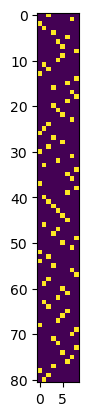

In [77]:
plt.imshow(train_data_logits[0])

In [78]:
show_sudoku(train_outputs[0])

+-------+-------+-------+
| 3 8 1 | 2 4 7 | 5 6 9 |
| 6 5 2 | 3 1 9 | 7 4 8 |
| 9 7 4 | 5 6 8 | 3 2 1 |
+-------+-------+-------+
| 4 6 3 | 1 8 5 | 2 9 7 |
| 8 1 9 | 7 2 3 | 4 5 6 |
| 7 2 5 | 4 9 6 | 8 1 3 |
+-------+-------+-------+
| 1 4 8 | 9 3 2 | 6 7 5 |
| 2 3 7 | 6 5 1 | 9 8 4 |
| 5 9 6 | 8 7 4 | 1 3 2 |
+-------+-------+-------+


In [96]:
class SudokuSampler(nn.Module, Sampleable):
    """
    Sampleable wrapper for the MNIST dataset
    """
    def __init__(self, train_data_logits, test_data_logits, train_inputs, test_inputs):
        super().__init__()
        self.dataset = train_data_logits
        self.masks = (train_inputs == 0).reshape((*train_inputs.shape, 1))
        self.test_dataset = test_data_logits
        self.test_masks = (test_inputs == 0).reshape((*test_inputs.shape, 1))
        #self.dummy = nn.Buffer(torch.zeros(1)) # Will automatically be moved when self.to(...) is called...
        self.register_buffer("dummy", torch.zeros(81))

    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, c, h, w)
            - labels: shape (batch_size, label_dim)
        """
        if num_samples > len(self.dataset):
            raise ValueError(f"num_samples exceeds dataset size: {len(self.dataset)}")
        
        indices = torch.randperm(len(self.dataset))[:num_samples]
        
        samples = [torch.Tensor(self.dataset[i]) for i in indices]
        masks = [torch.Tensor(self.masks[i]) for i in indices]
        
        samples = torch.stack(samples).to(self.dummy)
        masks = torch.stack(masks).to(self.dummy)

        labels = samples*(1-masks)
        return samples, labels

alpha_0= tensor([[[[0.]]]])
alpha_1= tensor([[[[1.]]]])
beta_0= tensor([[[[1.]]]])
beta_1= tensor([[[[0.]]]])


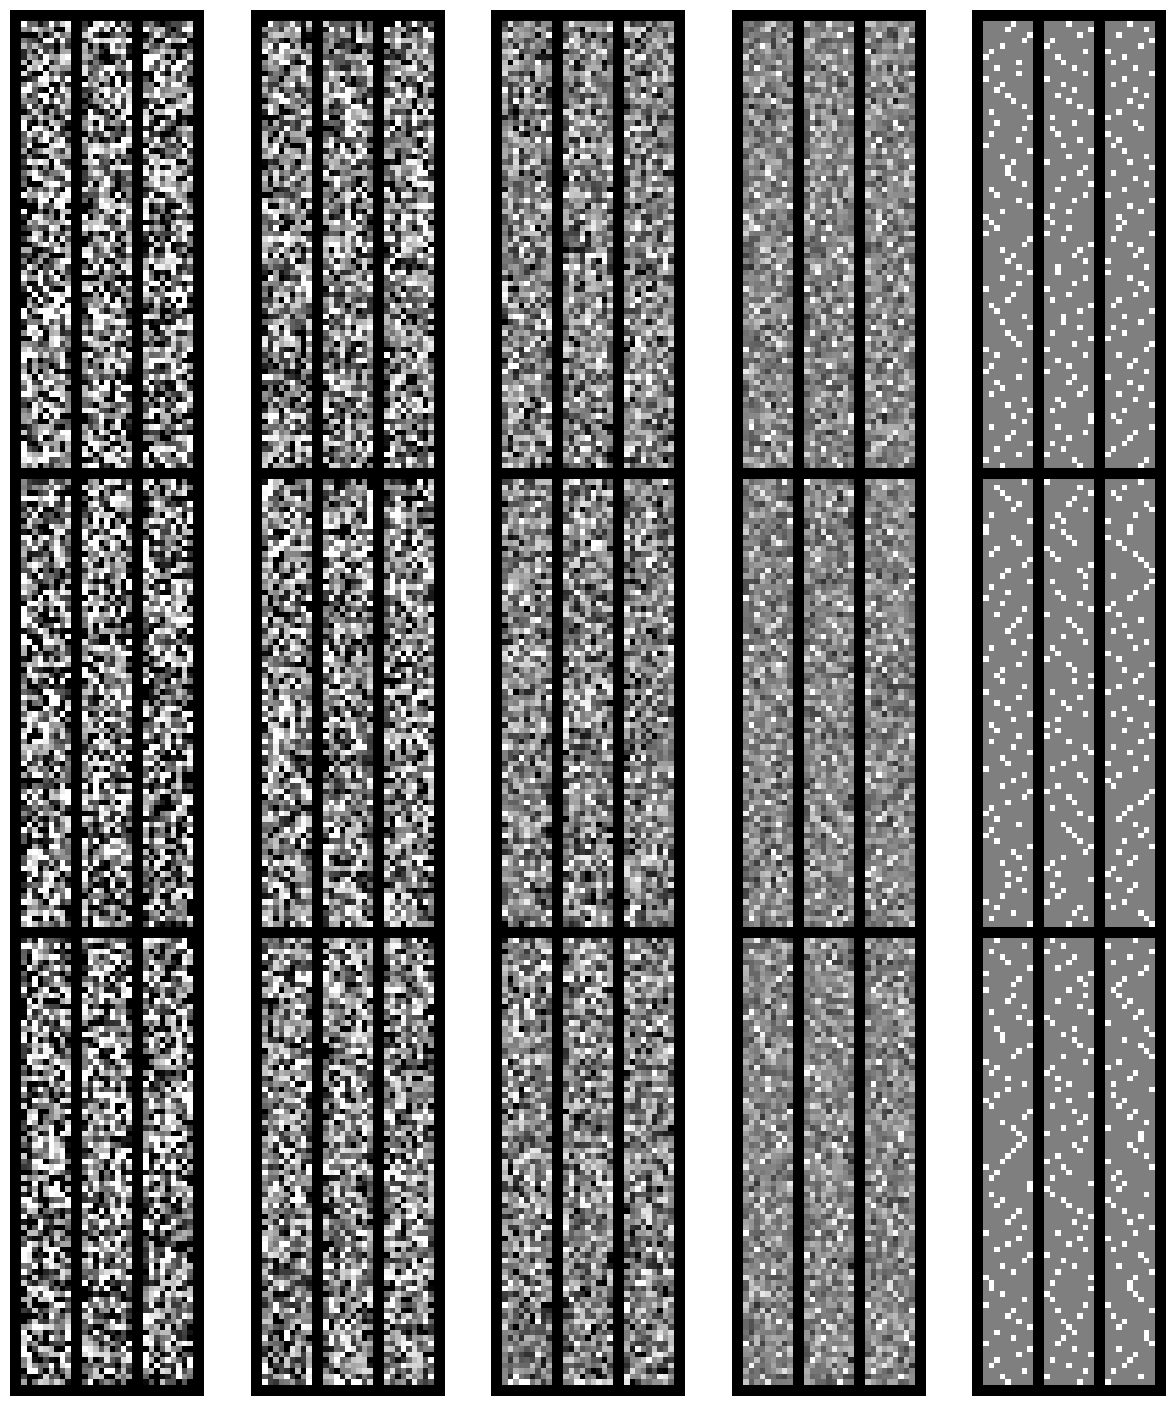

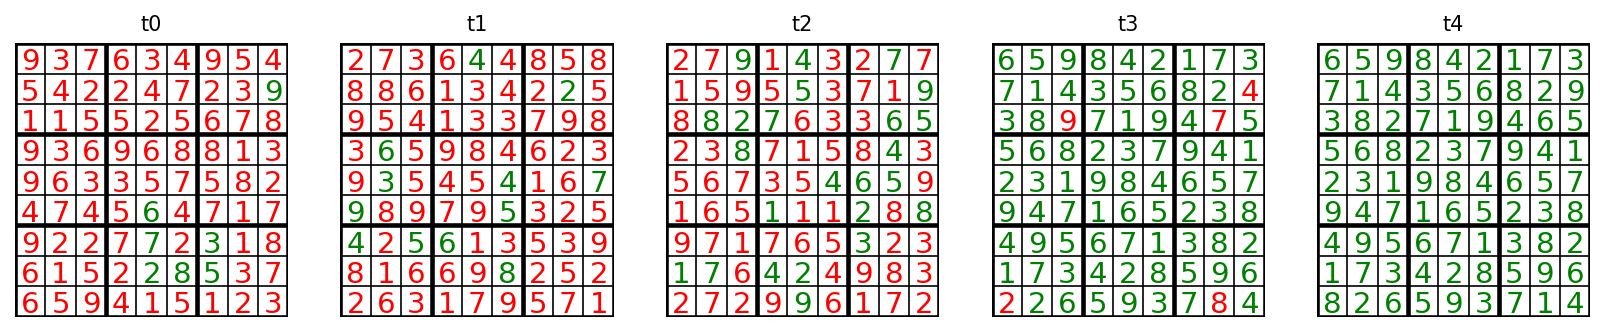

In [97]:
num_rows = 3
num_cols = 3
num_timesteps = 5

# Initialize our sampler
sampler = SudokuSampler(train_data_logits, test_data_logits, train_outputs, test_outputs).to(device)

# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = sampler,
    p_simple_shape = [81, 9],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Sample 
num_samples = num_rows * num_cols
z, _ = path.p_data.sample(num_samples)
z = z.view(-1, 1, 81, 9)

# Setup plot
fig, axes = plt.subplots(1, num_timesteps, figsize=(num_cols * num_timesteps, 6 * num_rows))

# Sample from conditional probability paths and graph
ts = torch.linspace(0, 1, num_timesteps).to(device)

cells_history = []
for tidx, t in enumerate(ts):
    tt = t.view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = path.sample_conditional_path(z, tt) # (num_samples, 1, 81, 9)
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[tidx].axis("off")

    cells_history.append(xt[0][0].argmax(axis=-1).to("cpu").numpy()+1)
plt.show()

gt = z[0, 0].argmax(dim=-1).cpu().numpy()+1     # (81,)
draw_sudoku_path(cells_history, gt=gt, titles=[f"t{i}" for i in range(len(cells_history))])

# Conditional vector field and conditional score (Gaussian paths)

In [98]:
class ConditionalVectorFieldODE(ODE):
    def __init__(self, path: ConditionalProbabilityPath, z: torch.Tensor):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, dim)
        """
        super().__init__()
        self.path = path
        self.z = z

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the conditional vector field u_t(x|z)
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        bs = x.shape[0]
        z = self.z.expand(bs, *self.z.shape[1:])
        return self.path.conditional_vector_field(x,z,t)

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 989.34it/s]


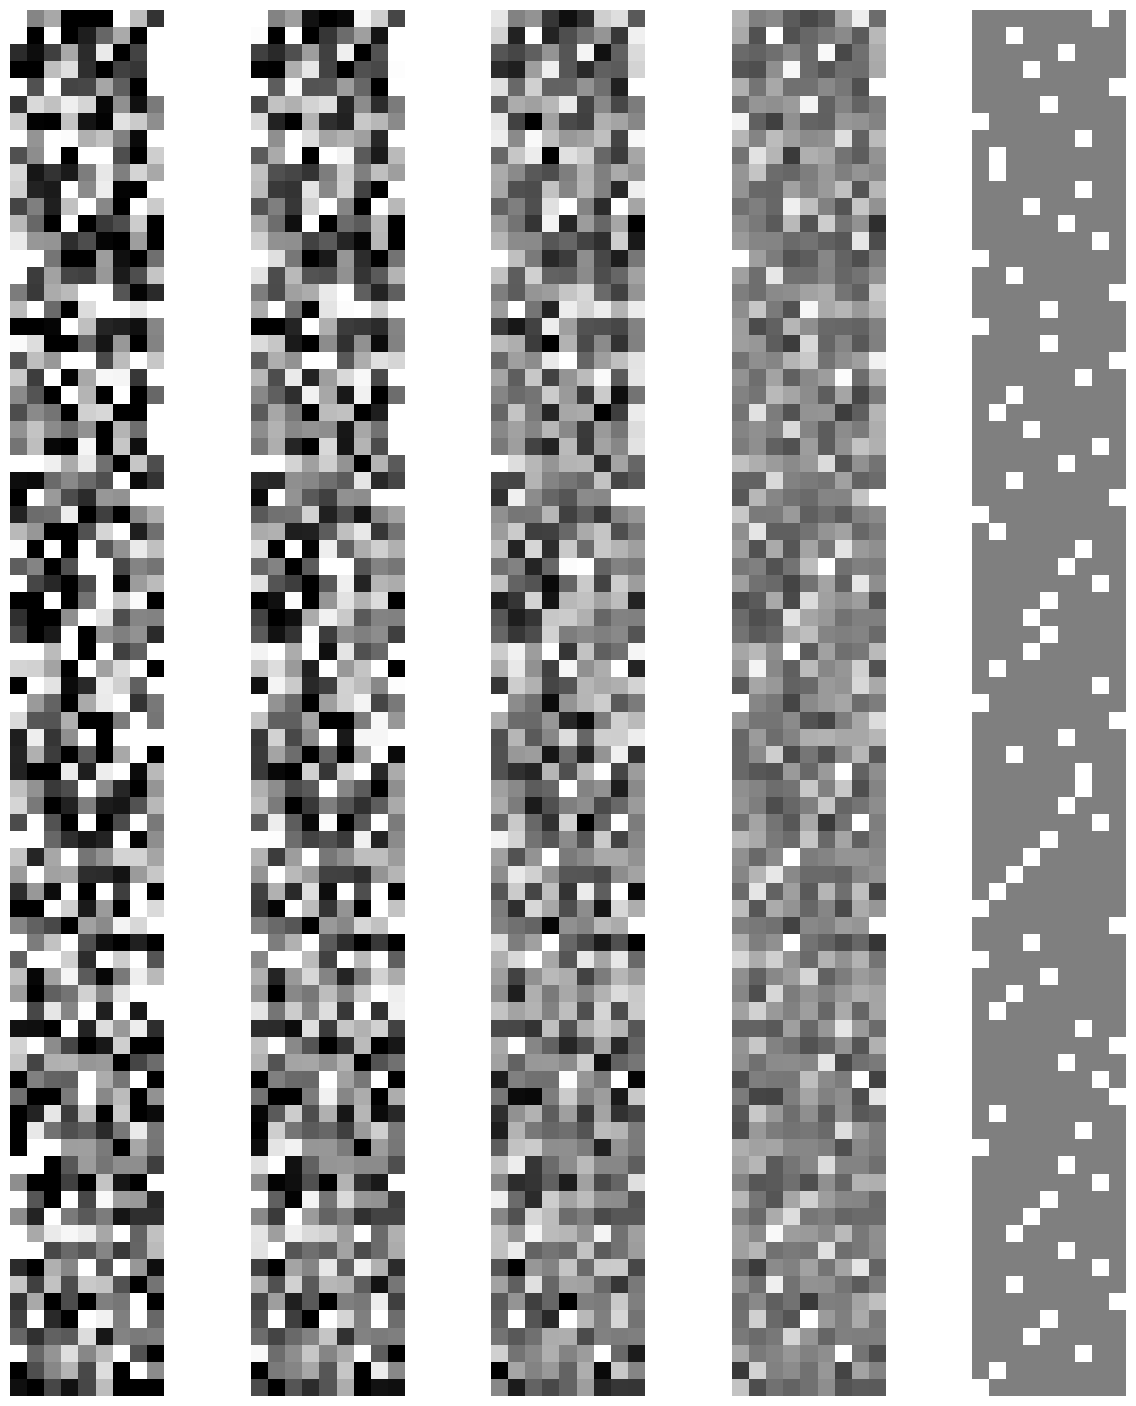

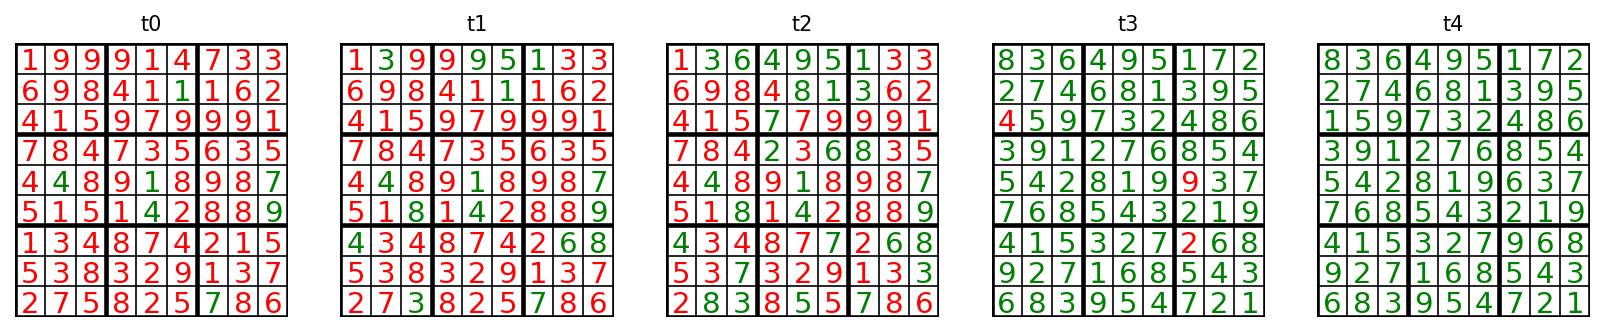

In [99]:
num_samples=  2
# Sample conditioning variable z
torch.cuda.manual_seed(1)
z, _ = path.sample_conditioning_variable(1) # (1,2)

# Construct integrator and plot trajectories
sigma = 0.5 # Can't make this too high or integration is numerically unstable!
ode = ConditionalVectorFieldODE(path, z)
simulator = EulerSimulator(ode)
x0, _ = path.p_simple.sample(num_samples) # (num_samples, 2)    
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1,1).expand(num_samples,-1,1,1).to(device) # (num_samples, nts, 1)

xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

fig, axes = plt.subplots(1, num_timesteps, figsize=(num_cols * num_timesteps, 6 * num_rows))

cells_history = []
ts = ts[0]
xts = xts[0]
for tidx, t in enumerate(ts):
    tt = t.view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = xts[tidx]
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[tidx].axis("off")

    cells_history.append(xt.argmax(axis=-1).to("cpu").numpy()+1)
plt.show()
gt = z[0].argmax(dim=-1).cpu().numpy()+1     # (81,)
draw_sudoku_path(cells_history, gt=gt, titles=[f"t{i}" for i in range(len(cells_history))])

In [100]:
class ConditionalVectorFieldSDE(SDE):
    def __init__(self, path: ConditionalProbabilityPath, z: torch.Tensor, sigma: float):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, ...)
        """
        super().__init__()
        self.path = path
        self.z = z
        self.sigma = sigma

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the conditional vector field u_t(x|z)
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        bs = x.shape[0]
        z = self.z.expand(bs, *self.z.shape[1:])
        return self.path.conditional_vector_field(x,z,t) + 0.5 * self.sigma**2 * self.path.conditional_score(x,z,t)

    def diffusion_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        return self.sigma * torch.randn_like(x)

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 423.82it/s]


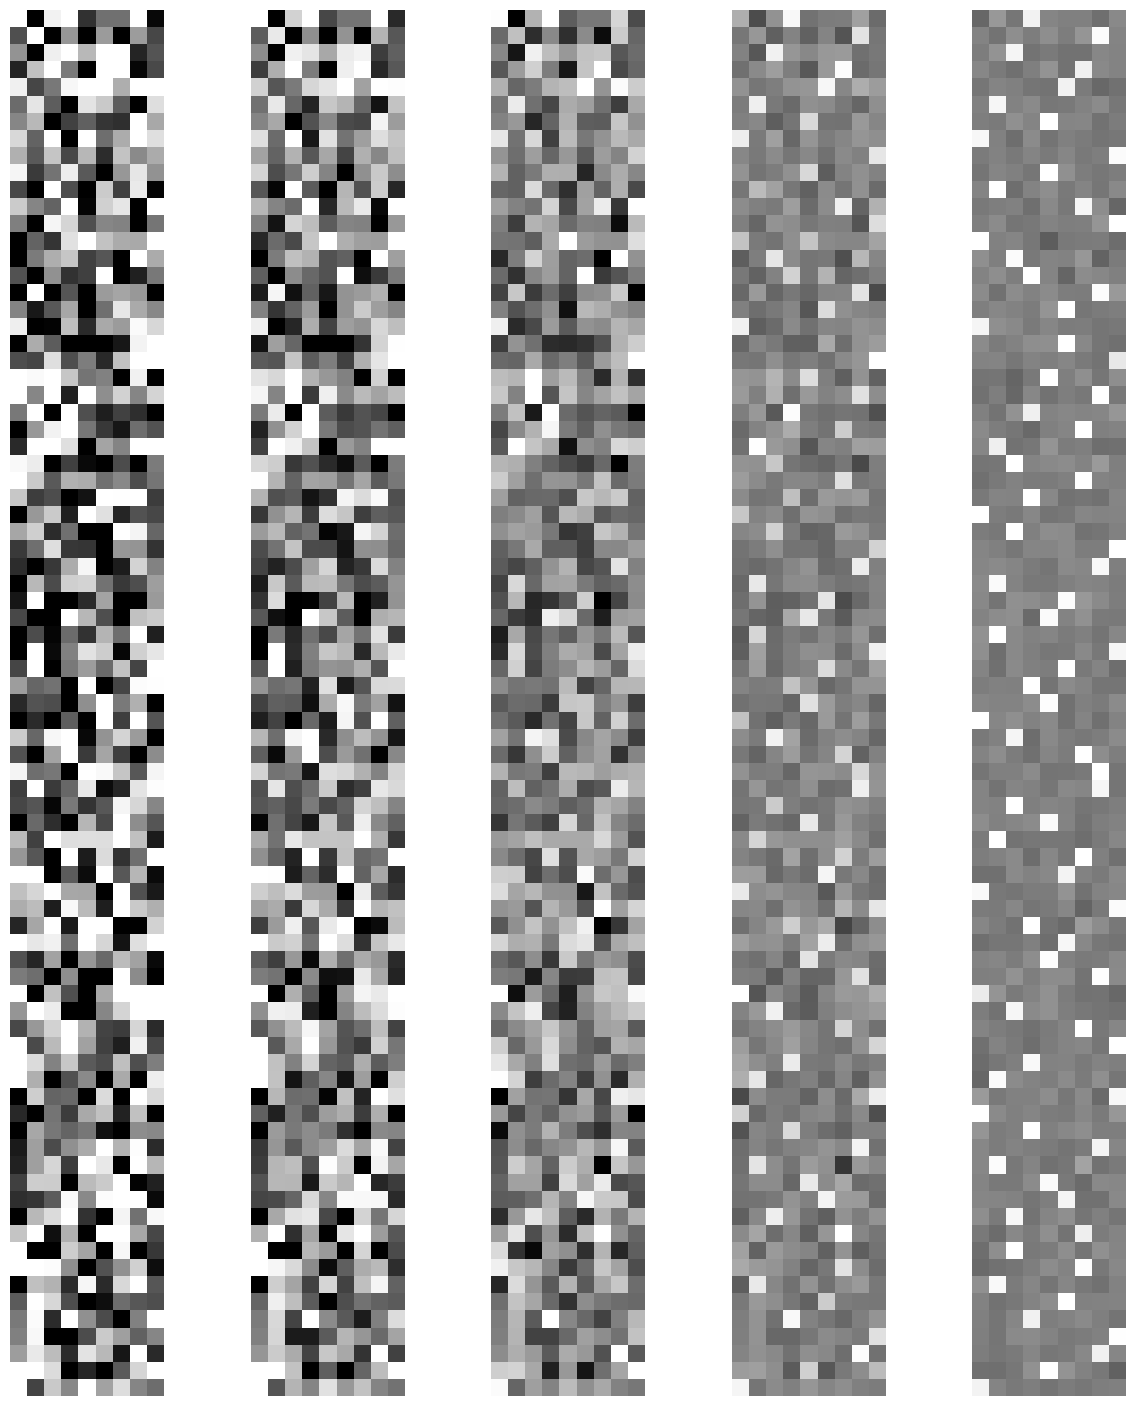

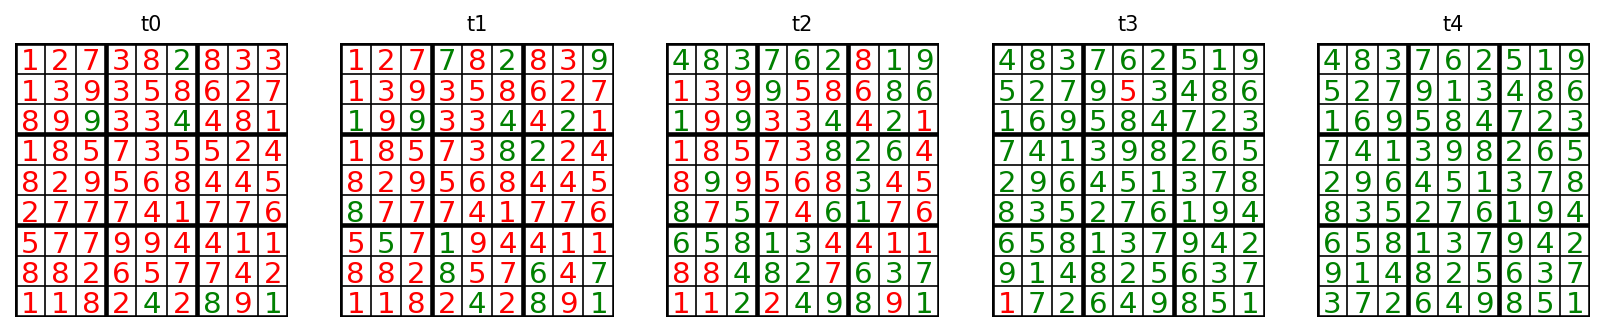

In [101]:
# Sample conditioning variable z
torch.cuda.manual_seed(1)
z, _ = path.sample_conditioning_variable(1) # (1,2)

# Construct integrator and plot trajectories
sigma = 0.5 # Can't make this too high or integration is numerically unstable!
ode = ConditionalVectorFieldSDE(path, z, sigma)
simulator = EulerSimulator(ode)
x0, _ = path.p_simple.sample(num_samples) # (num_samples, 2)    
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1,1).expand(num_samples,-1,1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

fig, axes = plt.subplots(1, num_timesteps, figsize=(num_cols * num_timesteps, 6 * num_rows))

cells_history = []
ts = ts[0]
xts = xts[0]
for tidx, t in enumerate(ts):
    tt = t.view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = xts[tidx]
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[tidx].axis("off")

    cells_history.append(xt.argmax(axis=-1).to("cpu").numpy()+1)
plt.show()
gt = z[0].argmax(dim=-1).cpu().numpy()+1     # (81,)
draw_sudoku_path(cells_history, gt=gt, titles=[f"t{i}" for i in range(len(cells_history))])

# Flow Matching with Gaussian Conditional Probability Paths

In [85]:

class TimeEmbedding(torch.nn.Module):
    def __init__(self, dim, freq=1000):
        super().__init__()
        half = dim//2
        omega = torch.exp(torch.linspace(0, math.log(freq), half))
        self.register_buffer("omega", omega)
        self.dim = dim
        
    def forward(self, t):
        x = 2*math.pi*t*self.omega[None, :]
        emb = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
        if self.dim%2:
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
        return emb
        
        
def build_mlp(dims: List[int], activation: Type[torch.nn.Module] = torch.nn.SiLU):
        mlp = []
        for idx in range(len(dims) - 1):
            mlp.append(torch.nn.Linear(dims[idx], dims[idx + 1]))
            if idx < len(dims) - 2:
                mlp.append(activation())
        return torch.nn.Sequential(*mlp)

class MLPVectorField(torch.nn.Module):
    """
    MLP-parameterization of the learned vector field u_t^theta(x)
    """
    def __init__(self, dim: int, hiddens: List[int], time_dim=64):
        super().__init__()
        self.dim = dim
        self.net = build_mlp([dim + time_dim] + hiddens + [dim])
        
        self.time_net = TimeEmbedding(time_dim)
        self.t_proj = nn.Sequential(nn.Linear(time_dim, time_dim), nn.SiLU(), nn.Linear(time_dim, time_dim))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        Returns:
        - u_t^theta(x): (bs, dim)
        """      
        t_emb = self.t_proj(self.time_net(t))
        xt = torch.cat([x,t_emb], dim=-1)
        return self.net(xt)        

In [86]:

# Same idea as before: fixed Fourier time features
class TimeFourier(nn.Module):
    def __init__(self, dim=64, max_freq=1000.0):
        super().__init__()
        half = dim // 2
        freqs = torch.exp(torch.linspace(0, math.log(max_freq), half))
        self.register_buffer("freqs", freqs)
        self.dim = dim

    def forward(self, t):
        # t: (B, 1)
        x = t * self.freqs[None, :] * 2 * math.pi  # (B, half)
        emb = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)  # (B, 2*half)
        if emb.shape[-1] < self.dim:  # odd dim safety
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
        return emb  # (B, dim)


class TransformerBlock(nn.Module):
    def __init__(self, hidden=128, heads=8, mlp_ratio=4.0, dropout=0.01):
        super().__init__()
        self.ln1 = nn.LayerNorm(hidden)
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden, num_heads=heads, dropout=dropout, batch_first=True
        )
        self.ln2 = nn.LayerNorm(hidden)

        mlp_hidden = int(hidden * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(hidden, mlp_hidden),
            nn.GELU(),
            nn.Linear(mlp_hidden, hidden),
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None, key_padding_mask=None):
        # x: (B, 81, hidden)
        h = self.ln1(x)
        a, _ = self.attn(h, h, h, attn_mask=attn_mask, key_padding_mask=key_padding_mask)
        x = x + self.drop(a)             # residual
        x = x + self.drop(self.mlp(self.ln2(x)))  # residual
        return x


class SudokuAttentionVectorField(nn.Module):
    """
    A simple attention-based vector field / refinement model.

    Inputs:
      z: (B, 81, 9)  - per-cell 9-dim state (logits/probs/features)
      t: (B, 1)      - time / step

    Output:
      dz: (B, 81, 9) - update direction (same shape as z)
    """
    def __init__(self, hidden: int = 128, depth: int = 4, heads: int = 8, t_dim: int = 64, dropout: float = 0.01):
        super().__init__()
        self.time = TimeFourier(t_dim)
        self.t_proj = nn.Sequential(
            nn.Linear(t_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
        )

        # project per-cell state (9) into hidden token embedding
        self.in_proj = nn.Linear(9, hidden)

        # positional identity for Sudoku grid
        self.row_emb = nn.Embedding(9, hidden)
        self.col_emb = nn.Embedding(9, hidden)
        self.box_emb = nn.Embedding(9, hidden)

        # precompute (81,) indices as buffers
        rows = torch.arange(81) // 9
        cols = torch.arange(81) % 9
        boxs = (rows // 3) * 3 + (cols // 3)
        self.register_buffer("row_idx", rows, persistent=False)
        self.register_buffer("col_idx", cols, persistent=False)
        self.register_buffer("box_idx", boxs, persistent=False)

        self.blocks = nn.ModuleList([
            TransformerBlock(hidden=hidden, heads=heads, dropout=dropout)
            for _ in range(depth)
        ])

        self.out_ln = nn.LayerNorm(hidden)
        self.out_proj = nn.Linear(hidden, 9)

    def forward(self, z: torch.Tensor, t: torch.Tensor, attn_mask=None) -> torch.Tensor:
        # z: (B,81,9), t: (B,1)
        x = self.in_proj(z)  # (B,81,H)

        # add Sudoku coordinate embeddings
        pos = (self.row_emb(self.row_idx) +
               self.col_emb(self.col_idx) +
               self.box_emb(self.box_idx))  # (81,H)
        x = x + pos[None, :, :]  # (B,81,H)

        te = self.t_proj(self.time(t))  # (B,H)
        x = x + te[:, None, :]          # broadcast add time conditioning

        for blk in self.blocks:
            x = blk(x, attn_mask=attn_mask)

        x = self.out_ln(x)
        dz = self.out_proj(x)  # (B,81,9)
        return dz


In [87]:
class Trainer(ABC):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def prepare_training(self, device: torch.device, lr: float = 1e-3):
        self.model.to(device)
        self.opt = self.get_optimizer(lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
        # Start

        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            self.opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            self.opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item()}')

            if epoch % 1000:
                torch.save(self.model.state_dict(), "model_128_square_time_tmp.pt")
                
        # Finish
        self.model.eval()

In [88]:
class ConditionalFlowMatchingTrainer(Trainer):
    def __init__(self, path: ConditionalProbabilityPath, model: MLPVectorField, **kwargs):
        super().__init__(model, **kwargs)
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        z, _ = self.path.p_data.sample(batch_size)

        eps = 10**(-4)
        u = torch.rand(batch_size, 1, 1)
        t = (1 - eps)*(1 - (1-u)**2)

        z = z.to(device)
        t = t.to(device)
        
        x = self.path.sample_conditional_path(z,t)

        model_u = self.model(x, t.reshape(t.shape[0], -1))#x.reshape(x.shape[0], -1),t.reshape(t.shape[0], -1))
        conditional_u = self.path.conditional_vector_field(x,z,t).reshape(model_u.shape)
        
        return torch.mean(torch.sum((model_u - conditional_u)**2, -1))

In [89]:
# Construct learnable vector field
flow_model = SudokuAttentionVectorField()#MLPVectorField(dim=81*9, hiddens=[1024,1024,1024,1024])


In [91]:
state_dict = torch.load("flow_model_128_square_time.pt", map_location="cpu")
flow_model.load_state_dict(state_dict)
flow_model = flow_model.to(device)

In [36]:
# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, flow_model)
trainer.prepare_training(device=device, lr=1e-5)

In [ ]:


losses = trainer.train(num_epochs=20_000, device=device, lr=1e-3, batch_size=128)

Epoch 79365, loss: 4.161885738372803: : 79366it [3:00:00,  7.23it/s] 

In [40]:
losses = trainer.train(num_epochs=10_000, device=device, lr=5e-4, batch_size=128)

Epoch 9999, loss: 1.2312016487121582: : 10000it [58:11,  2.86it/s]


In [34]:
losses = trainer.train(num_epochs=2, device=device, lr=5e-4, batch_size=128)

Epoch 1, loss: 3.2692675590515137: : 2it [00:00,  3.26it/s]


In [54]:
losses = trainer.train(num_epochs=10_000, device=device, lr=5e-4, batch_size=128)

Epoch 9999, loss: 0.8558639883995056: : 10000it [19:59,  8.34it/s]


In [57]:
losses = trainer.train(num_epochs=10_000, device=device, lr=5e-4, batch_size=128)

Epoch 9999, loss: 1.05331552028656: : 10000it [19:55,  8.36it/s] 


In [59]:
losses = trainer.train(num_epochs=10_000, device=device, lr=1e-4, batch_size=128)

Epoch 9999, loss: 1.064245581626892: : 10000it [19:55,  8.36it/s]


In [62]:
losses = trainer.train(num_epochs=10_000, device=device, lr=1e-4, batch_size=160)

Epoch 9999, loss: 0.8892953991889954: : 10000it [24:53,  6.70it/s]


In [68]:
losses = trainer.train(num_epochs=10_000, device=device, lr=1e-4, batch_size=160)

Epoch 9999, loss: 0.8691661953926086: : 10000it [29:27,  5.66it/s]


In [73]:
losses = trainer.train(num_epochs=10_000, device=device, lr=5e-5, batch_size=160)

Epoch 9999, loss: 0.7972108125686646: : 10000it [24:40,  6.76it/s]


In [76]:
losses = trainer.train(num_epochs=10_000, device=device, lr=2e-5, batch_size=160)

Epoch 9999, loss: 0.8194925785064697: : 10000it [25:43,  6.48it/s]


In [88]:
losses = trainer.train(num_epochs=5_000, device=device, lr=1e-5, batch_size=160)

Epoch 4999, loss: 0.8793537020683289: : 5000it [26:46,  3.11it/s]


In [108]:
losses = trainer.train(num_epochs=10_000, device=device, lr=1e-4, batch_size=160)

Epoch 9999, loss: 0.8408680558204651: : 10000it [24:45,  6.73it/s]


In [112]:
losses = trainer.train(num_epochs=10_000, device=device, lr=1e-4, batch_size=256)

Epoch 9999, loss: 0.8086398839950562: : 10000it [39:00,  4.27it/s]


In [115]:
losses = trainer.train(num_epochs=10_000, device=device, lr=1e-5, batch_size=256)

Epoch 9999, loss: 0.8233801126480103: : 10000it [42:56,  3.88it/s]


In [125]:
losses = trainer.train(num_epochs=10_000, device=device, lr=1e-5, batch_size=256)

Epoch 9999, loss: 0.8338719010353088: : 10000it [38:35,  4.32it/s]


In [128]:
losses = trainer.train(num_epochs=10_000, device=device, lr=1e-6, batch_size=256)

Epoch 9999, loss: 0.8030602931976318: : 10000it [38:45,  4.30it/s]


In [133]:
losses = trainer.train(num_epochs=10_000, device=device, lr=1e-5, batch_size=256)

Epoch 9999, loss: 0.7465189099311829: : 10000it [38:47,  4.30it/s]


In [ ]:
losses = trainer.train(num_epochs=120_000, device=device, lr=1e-6, batch_size=256)

Epoch 52723, loss: 0.7659249305725098: : 52723it [3:53:41,  3.76it/s]

In [ ]:
losses = trainer.train(num_epochs=50_000, device=device, lr=5e-5, batch_size=64)

In [ ]:
losses = trainer.train(num_epochs=50_000, device=device, lr=1e-5, batch_size=64)

In [ ]:
losses = trainer.train(num_epochs=10_000, device=device, lr=1e-5, batch_size=64)

In [ ]:
losses = trainer.train(num_epochs=1_000_000, device=device, lr=1e-5, batch_size=64)

In [102]:
class LearnedVectorFieldODE(ODE):
    def __init__(self, net: MLPVectorField):
        self.net = net

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: (bs, dim)
            - t: (bs, dim)
        Returns:
            - u_t: (bs, dim)
        """
        initial_shape = x.shape
        #x = x.reshape(x.shape[0], -1)
        t = t.reshape(t.shape[0], -1)
        return self.net(x, t).reshape(initial_shape)

100%|█████████████████████████████████████████| 199/199 [01:51<00:00,  1.78it/s]


Valid sudokus:2/500


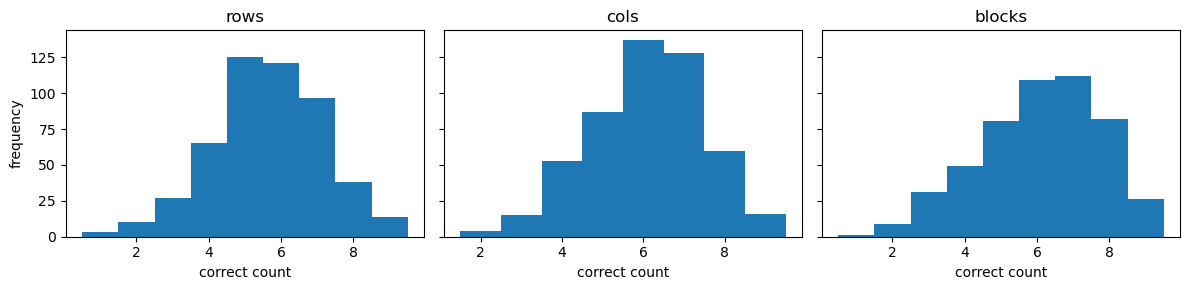

[5.648 6.084 6.082] [1.53365446 1.41878258 1.67071123]
5.938 1.5580402219882943
[9 9 9] [1 2 1]
9.0


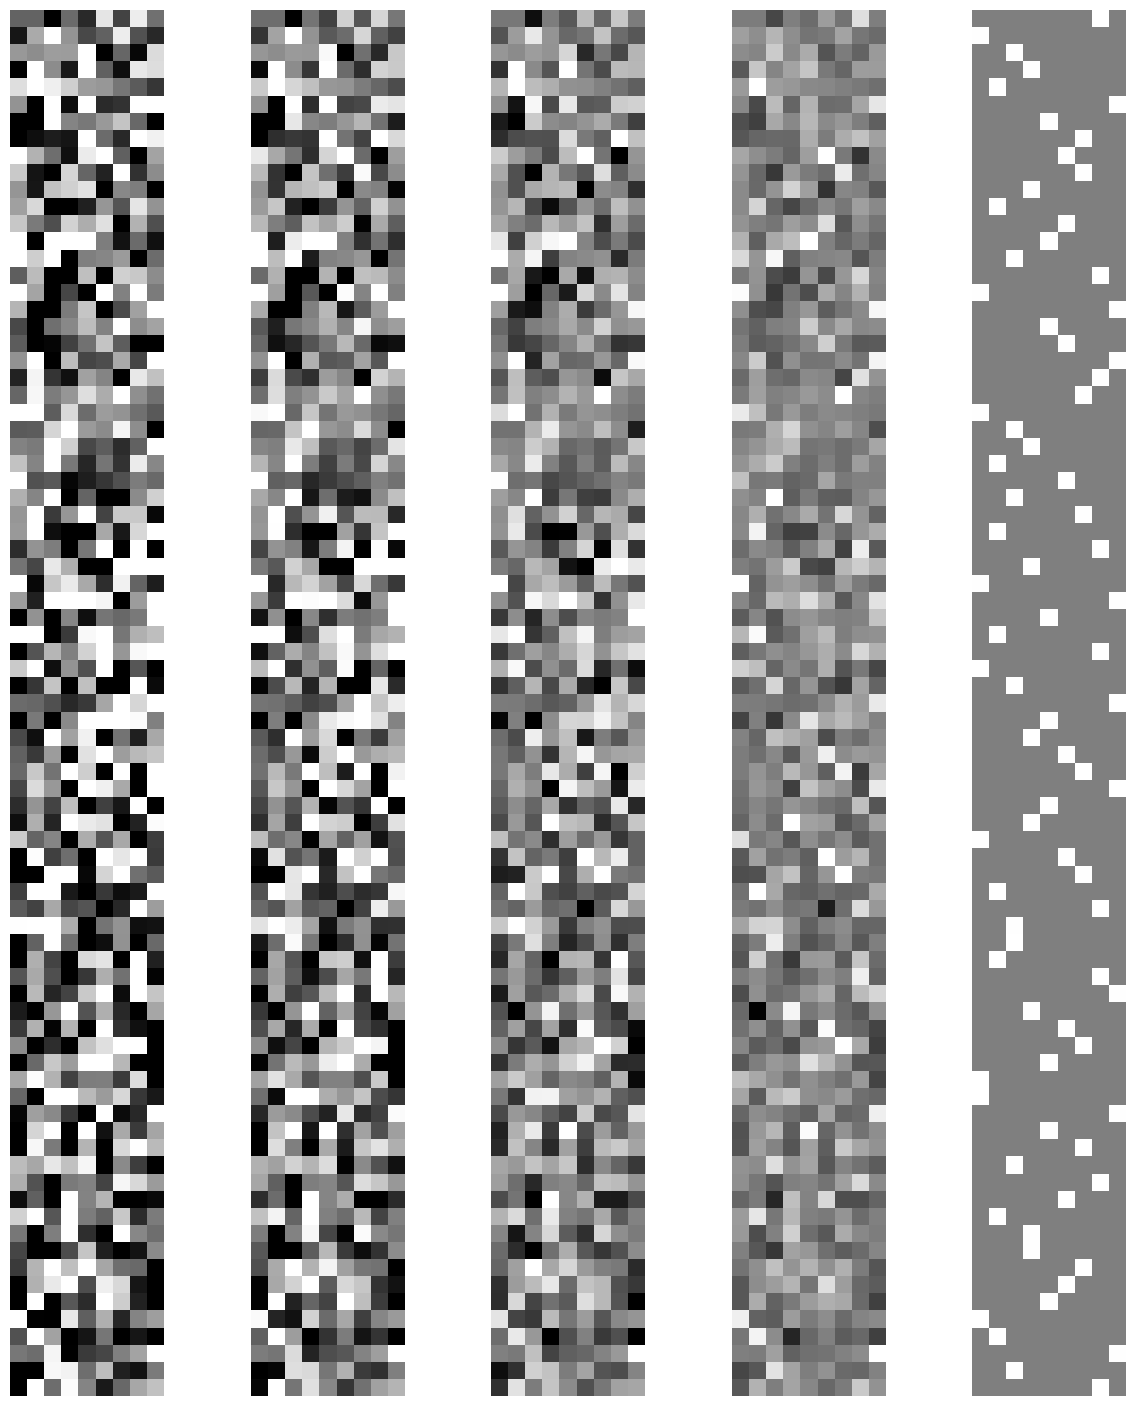

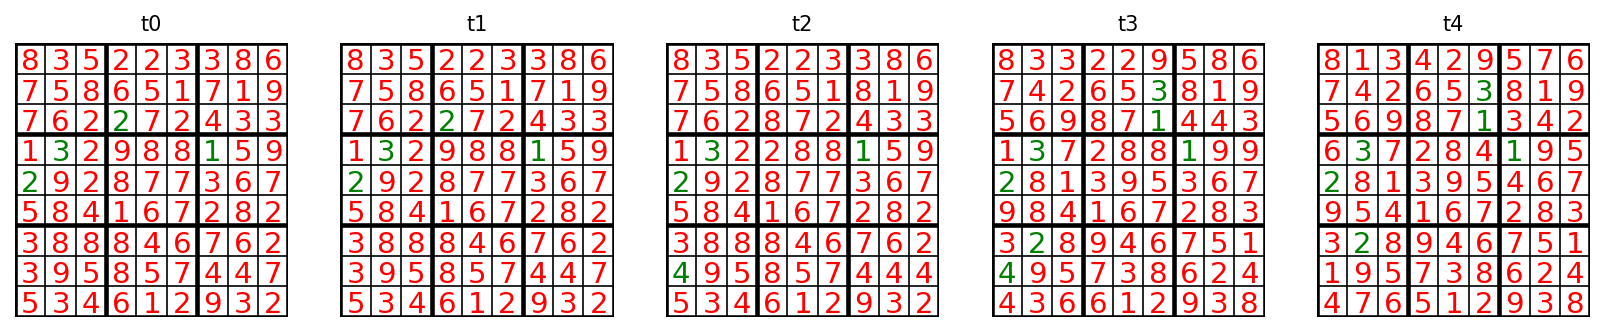

In [109]:
num_samples=500
num_timesteps = 200
num_marginals = 4

# Sample conditioning variable z
torch.cuda.manual_seed(1)
z, _ = path.sample_conditioning_variable(1) # (1,2)

# Construct integrator and plot trajectories
sigma = 0.5 # Can't make this too high or integration is numerically unstable!

ode = LearnedVectorFieldODE(flow_model)
simulator = EulerSimulator(ode)

x0, _ = path.p_simple.sample(num_samples) # (num_samples, 2)    
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1,1).expand(num_samples,-1,1,1).to(device) # (num_samples, nts, 1)

xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

solutions = xts[:, -1].argmax(dim=-1).cpu().numpy()

print(f"Valid sudokus:{np.sum([valid_sudoku81(sol+1) for sol in solutions])}/{len(solutions)}")

report = [sudoku81_report(sol+1) for sol in solutions]
report = np.array(report)

labels = ["rows", "cols", "blocks"]

fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for i in range(3):
    ax[i].hist(report[:, i], bins=np.arange(report[:, i].min(), report[:, i].max()+2)-0.5)
    ax[i].set_title(labels[i])
    ax[i].set_xlabel("correct count")
ax[0].set_ylabel("frequency")
plt.tight_layout()
plt.show()

print(np.mean(report, 0), np.std(report, 0))
print(np.mean(report), np.std(report))
print(np.max(report, 0), np.min(report, 0))
print(np.max(np.mean(report, -1)))

i = 0
if np.max(np.mean(report, -1)) == 9:
    i = np.argmax(np.mean(report, -1))

indexes = np.where(np.mean(report, -1) == 9)

cells_history = []
# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)

xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)

fig, axes = plt.subplots(1, xts_every_n.shape[1], figsize=(num_cols * xts_every_n.shape[1], 6 * num_rows))

for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = xts_every_n[i, plot_idx]
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[plot_idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[plot_idx].axis("off")

    cells_history.append(xt.argmax(axis=-1).to("cpu").numpy()+1)
plt.show()
gt = z[0].argmax(dim=-1).cpu().numpy()+1     # (81,)
draw_sudoku_path(cells_history, gt=gt, titles=[f"t{i}" for i in range(len(cells_history))])

In [ ]:
for idx in indexes:
    found_solution = torch.argmax(xts[idx, -1], -1).cpu().numpy()
    for solution in train_outputs:
        if np.sum(np.abs(solution - found_solution)) == 0:
            print(f"Solution {idx} was present in the training set.")
            break

In [64]:


num_gif_frames = 40
resize_factor = 5
title_text = "Sudoku ODE generation"
fps = 10

def sudoku81_report(s):
    if len(s) != 81:
        return 0, 0, 0
    s = [int(x) for x in s]
    ok = set(range(1, 10))
    rows = sum(set(s[i*9:(i+1)*9]) == ok for i in range(9))
    cols = sum(set(s[i::9]) == ok for i in range(9))
    blks = sum(
        set(s[(i//3)*27 + (i%3)*3 + r*9 + c] for r in range(3) for c in range(3)) == ok
        for i in range(9)
    )
    return rows, cols, blks

font = ImageFont.load_default()

gif_frames = np.linspace(0, num_timesteps - 1, num_gif_frames, dtype=int)
gif_images = []

# Layout knobs (tune these if you want)
SIDE_PAD = 100
HEADER_H = 80
FOOTER_H = 120
BG = (255, 255, 255)
FG = (0, 0, 0)

for k, t_idx in enumerate(gif_frames):
    xt = xts[i, t_idx]

    # ---- make the "imshow" image for this timestep ----
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1, 1))
    img = grid.permute(1, 2, 0).detach().cpu().numpy()
    img = ((img - img.min()) / (img.max() - img.min() + 1e-8) * 255).astype(np.uint8)

    pil_img = Image.fromarray(img)
    w, h = pil_img.size
    pil_img = pil_img.resize((w * resize_factor, h * resize_factor), resample=Image.NEAREST).convert("RGB")

    # ---- compute report + time ----
    cells = (xt.argmax(dim=-1).detach().cpu().numpy() + 1).reshape(-1)  # length 81
    rows, cols, blks = sudoku81_report(cells)

    t = float(t_idx) / float(num_timesteps - 1) if num_timesteps > 1 else 0.0

    # ---- Create canvas FIRST, then paste image into the body area ----
    canvas_w = pil_img.width + 2 * SIDE_PAD
    canvas_h = HEADER_H + pil_img.height + FOOTER_H

    frame = Image.new("RGB", (canvas_w, canvas_h), BG)
    draw = ImageDraw.Draw(frame)

    # paste the image centered in the body area
    body_x0 = SIDE_PAD
    body_y0 = HEADER_H
    frame.paste(pil_img, (body_x0, body_y0))

    # ---- Header: title ----
    title_bbox = draw.textbbox((0, 0), title_text, font=font)
    title_w = title_bbox[2] - title_bbox[0]
    title_h = title_bbox[3] - title_bbox[1]
    draw.text(((canvas_w - title_w) // 2, (HEADER_H - title_h) // 2), title_text, fill=FG, font=font)

    # ---- Footer: progress bar + time + stats ----
    footer_top = HEADER_H + pil_img.height

    # progress bar
    bar_margin_x = 40
    bar_w = canvas_w - 2 * bar_margin_x
    bar_h = 12
    bar_x0 = bar_margin_x
    bar_y0 = footer_top + 18

    draw.rectangle([bar_x0, bar_y0, bar_x0 + bar_w, bar_y0 + bar_h], outline=FG, width=2)
    fill_w = int(bar_w * max(0.0, min(1.0, t)))
    if fill_w > 0:
        draw.rectangle([bar_x0, bar_y0, bar_x0 + fill_w, bar_y0 + bar_h], fill=FG)

    time_text = f"t = {t:.3f}   frame {k+1}/{len(gif_frames)}"
    draw.text((bar_x0, bar_y0 + bar_h + 10), time_text, fill=FG, font=font)

    stats_text = f"rows: {rows}/9   cols: {cols}/9   blocks: {blks}/9"
    stats_bbox = draw.textbbox((0, 0), stats_text, font=font)
    stats_w = stats_bbox[2] - stats_bbox[0]
    draw.text(((canvas_w - stats_w) // 2, footer_top + 70), stats_text, fill=FG, font=font)

    gif_images.append(np.array(frame))

out_path = "sudoku_trajectory_ODE_fancy2.gif"
imageio.mimsave(out_path, gif_images, fps=fps)
print(f"Saved {out_path}")


Saved sudoku_trajectory_ODE_fancy2.gif


In [ ]:
def to_numpy(x):
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().float().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x, dtype=np.float32)

def reshape_sudoku_probs(x_t81_9):
    x = to_numpy(x_t81_9)
    assert x.ndim == 3 and x.shape[1] == 81 and x.shape[2] == 9, f"Expected [T,81,9], got {x.shape}"
    return x.reshape(x.shape[0], 9, 9, 9)

def renormalize_per_cell(p_t99d, eps=1e-8):
    """
    Ensures last dim sums to 1. If your tensor is logits or drifts, this fixes it.
    """
    p = np.asarray(p_t99d, dtype=np.float32)
    s = p.sum(axis=-1, keepdims=True)
    s = np.where(s < eps, 1.0, s)
    return np.clip(p / s, 0.0, 1.0)

def entropy_map(p_t99d, eps=1e-8):
    p = np.clip(p_t99d, eps, 1.0)
    H = -(p * np.log(p)).sum(axis=-1)          # [T,9,9]
    Hmax = np.log(p.shape[-1])
    return H, (H / Hmax)

def confidence_map(p_t99d):
    pred = p_t99d.argmax(axis=-1)              # [T,9,9] in 0..8
    conf = p_t99d.max(axis=-1)                 # [T,9,9] in [1/9..1]
    return conf, pred

def render_entropy_gif(
    p_t99d,
    out_path="entropy.gif",
    fps=20,
    cmap="magma",
    show_digits=True,
    digit_alpha_floor=0.15,
    add_grid=True
):
    import matplotlib.pyplot as plt
    import imageio.v2 as imageio

    p = renormalize_per_cell(p_t99d)  # important
    _, Hn = entropy_map(p)
    conf, pred = confidence_map(p)

    frames = []
    T = p.shape[0]

    vmin, vmax = 0.0, 1.0

    for t in range(T):
        fig, ax = plt.subplots(figsize=(5.6, 5.6), dpi=160)

        im = ax.imshow(Hn[t], vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(f"Sudoku entropy (normalized)   t={t}")

        ax.set_xticks(np.arange(9))
        ax.set_yticks(np.arange(9))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlim(-0.5, 8.5)
        ax.set_ylim(8.5, -0.5)

        if add_grid:
            # thin cell grid
            for k in range(10):
                lw = 1.0
                ax.axhline(k - 0.5, linewidth=lw)
                ax.axvline(k - 0.5, linewidth=lw)

            # bold 3x3 block borders
            for k in [0, 3, 6, 9]:
                ax.axhline(k - 0.5, linewidth=3.2)
                ax.axvline(k - 0.5, linewidth=3.2)

        if show_digits:
            for r in range(9):
                for c in range(9):
                    d = int(pred[t, r, c]) + 1
                    a = float(conf[t, r, c])
                    ax.text(
                        c, r, str(d),
                        ha="center", va="center",
                        fontsize=12,
                        color="white",
                        alpha=np.clip(a, digit_alpha_floor, 1.0)
                    )

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.03)
        cbar.set_label("entropy (0=confident, 1=uniform)")

        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)
    for _ in range(20):
        frames.append(frames[-1])
    imageio.mimsave(out_path, frames, fps=fps)
    return out_path
p = reshape_sudoku_probs(x)  # x is [T,81,9]

render_entropy_gif(p, "entropy.gif", fps=20, show_digits=True)

# Relation between conditional vector field and conditional score function.

Analytically, for Gaussian paths, the score function can be expressed in terms of the  vector field as

$$s_t^{\theta}(x) = \frac{\alpha_t u_t^{\theta}(x) - \dot{\alpha}_t x}{\beta_t^{2}\,\dot{\alpha}_t-\alpha_t\,\dot{\beta}_t\,\beta_t}$$

Here we defien the score function, using this formula, and inject this into SDE.


In [112]:
class LangevinFlowSDE(SDE):
    def __init__(self, flow_model: MLPVectorField, path : ConditionalProbabilityPath, sigma: float):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, dim)
        """
        super().__init__()
        self.flow_model = flow_model
        self.sigma = sigma
        self.path = path

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        t = t.reshape(t.shape[0], -1)
        u_t = self.flow_model(x,t)
        denominator = (self.path.alpha.dt(t)*self.path.beta(t)**2 - self.path.alpha(t)*self.path.beta.dt(t)*self.path.beta(t))
        
        alpha = self.path.alpha(t)
        alpha = alpha.reshape(alpha.shape[0], 1, 1)
        alpha_prime = self.path.alpha.dt(t).reshape(alpha.shape[0], 1, 1)
        denominator = denominator.reshape(denominator.shape[0], 1, 1)
        
        s_t = (alpha*u_t - alpha_prime*x)/denominator
        
        return u_t + 0.5 * self.sigma ** 2 * s_t

    def diffusion_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        return self.sigma * torch.randn_like(x)

100%|█████████████████████████████████████████| 299/299 [02:53<00:00,  1.72it/s]


Valid sudokus:1/500


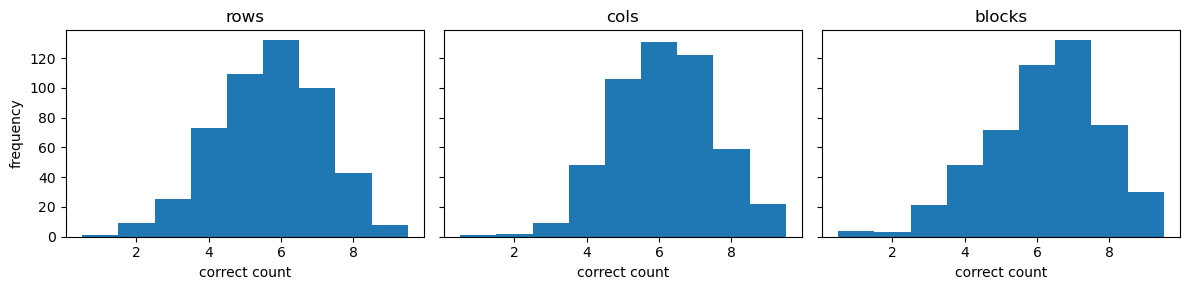

[5.678 6.128 6.218] [1.4745562  1.40271736 1.59952368]
6.008 1.5130331567197504
[9 9 9] [1 1 1]
9.0


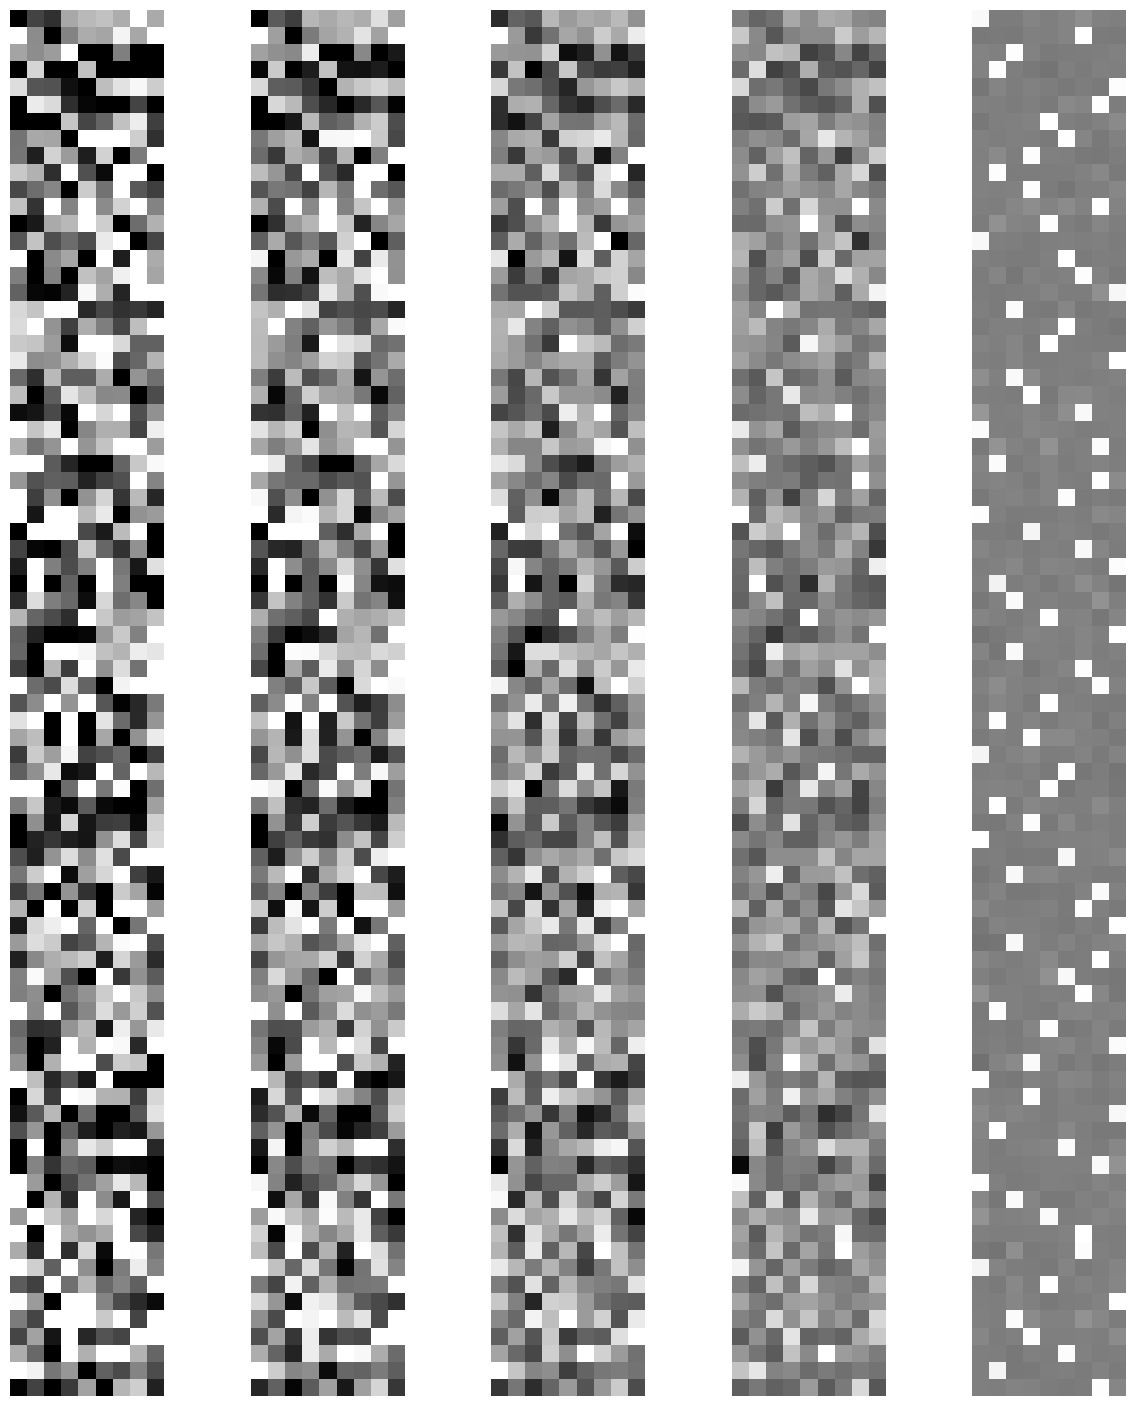

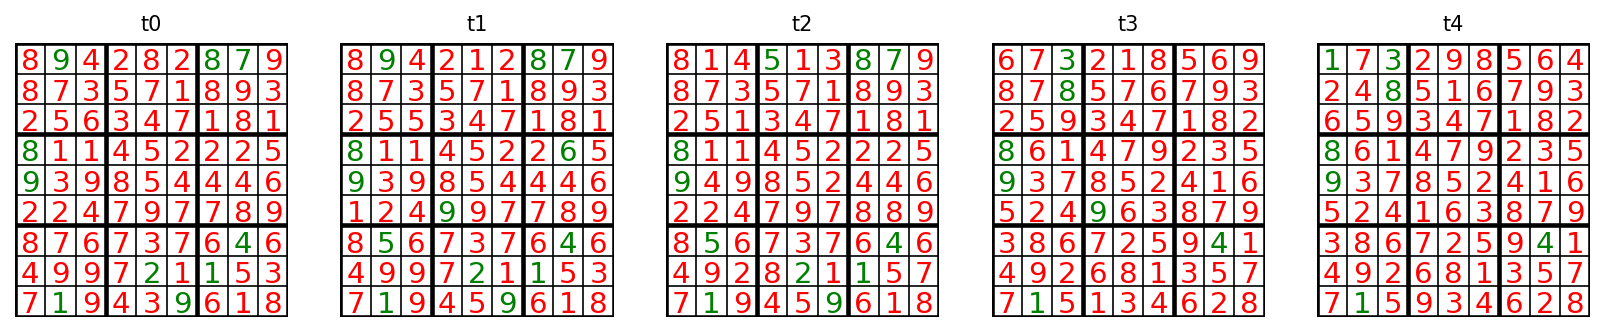

In [113]:
num_samples=500
num_timesteps = 300
num_marginals = 4


# Sample conditioning variable z
torch.cuda.manual_seed(1)
z, _ = path.sample_conditioning_variable(1) # (1,2)

# Construct integrator and plot trajectories
sigma = 0.2 # Can't make this too high or integration is numerically unstable!

sde = LangevinFlowSDE(flow_model, path, sigma)
simulator = EulerMaruyamaSimulator(sde)

x0, _ = path.p_simple.sample(num_samples) # (num_samples, 2)    
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1,1).expand(num_samples,-1,1,1).to(device) # (num_samples, nts, 1)

xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

solutions = xts[:, -1].argmax(dim=-1).cpu().numpy()

print(f"Valid sudokus:{np.sum([valid_sudoku81(sol+1) for sol in solutions])}/{len(solutions)}")

report = [sudoku81_report(sol+1) for sol in solutions]
report = np.array(report)

labels = ["rows", "cols", "blocks"]

fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for i in range(3):
    ax[i].hist(report[:, i], bins=np.arange(report[:, i].min(), report[:, i].max()+2)-0.5)
    ax[i].set_title(labels[i])
    ax[i].set_xlabel("correct count")
ax[0].set_ylabel("frequency")
plt.tight_layout()
plt.show()

print(np.mean(report, 0), np.std(report, 0))
print(np.mean(report), np.std(report))
print(np.max(report, 0), np.min(report, 0))
print(np.max(np.mean(report, -1)))
i = 0
if np.max(np.mean(report, -1)) == 9:
    i = np.argmax(np.mean(report, -1))

indexes = np.where(np.mean(report, -1) == 9)

cells_history = []
# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)

xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)

fig, axes = plt.subplots(1, xts_every_n.shape[1], figsize=(num_cols * xts_every_n.shape[1], 6 * num_rows))

for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = xts_every_n[i, plot_idx]
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[plot_idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[plot_idx].axis("off")

    cells_history.append(xt.argmax(axis=-1).to("cpu").numpy()+1)
plt.show()
gt = z[0].argmax(dim=-1).cpu().numpy()+1     # (81,)
draw_sudoku_path(cells_history, gt=gt, titles=[f"t{i}" for i in range(len(cells_history))])

# Score matching

Here we train a separate network to estimate the score function.

In [116]:
class ConditionalScoreMatchingTrainer(Trainer):
    def __init__(self, path: ConditionalProbabilityPath, model: SudokuAttentionVectorField, **kwargs):
        super().__init__(model, **kwargs)
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        z, _ = self.path.p_data.sample(batch_size)

        eps = 10**(-4)
        u = torch.rand(batch_size, 1, 1)
        t = (1 - eps)*(1 - (1-u)**2)

        z = z.to(device)
        t = t.to(device)
        
        x = self.path.sample_conditional_path(z,t)
        
        delta_p, beta_2 = self.path.conditional_score_no_beta(x,z,t)
        score_t = self.model(x,t.reshape(t.shape[0], -1))
        
        return torch.mean(torch.sum((score_t*beta_2 - delta_p)**2, -1))

In [117]:
score_model = SudokuAttentionVectorField()

In [118]:
state_dict = torch.load("score_model_128_square_time.pt", map_location="cpu")
score_model.load_state_dict(state_dict)
score_model = score_model.to(device)

In [52]:
trainer = ConditionalScoreMatchingTrainer(path, score_model)
trainer.prepare_training(device=device, lr=1e-5)

In [53]:
losses = trainer.train(num_epochs=1000, device=device, lr=1e-3, batch_size=256)

Epoch 999, loss: 0.36225542426109314: : 1000it [11:15,  1.48it/s]


In [207]:
losses = trainer.train(num_epochs=5_000, device=device, lr=1e-3, batch_size=256)

Epoch 4999, loss: 0.12049837410449982: : 5000it [22:38,  3.68it/s]


In [57]:
losses = trainer.train(num_epochs=10_000, device=device, lr=1e-3, batch_size=256)

Epoch 9999, loss: 0.16040554642677307: : 10000it [42:28,  3.92it/s]


In [58]:
losses = trainer.train(num_epochs=1_000, device=device, lr=1e-4, batch_size=256)

Epoch 999, loss: 0.15436546504497528: : 1000it [04:25,  3.76it/s]


In [59]:
losses = trainer.train(num_epochs=1_000, device=device, lr=1e-4, batch_size=256)

Epoch 999, loss: 0.15113820135593414: : 1000it [04:25,  3.77it/s]


In [229]:
losses = trainer.train(num_epochs=5_000, device=device, lr=1e-4, batch_size=256)

Epoch 4999, loss: 0.07316028326749802: : 5000it [23:13,  3.59it/s]


In [233]:
losses = trainer.train(num_epochs=10_000, device=device, lr=1e-4, batch_size=256)

Epoch 9999, loss: 0.07071556895971298: : 10000it [45:30,  3.66it/s]


In [119]:
class LangevinFlowSDE(SDE):
    def __init__(self, flow_model: MLPVectorField, score_model: MLPVectorField, sigma: float):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, dim)
        """
        super().__init__()
        self.flow_model = flow_model
        self.score_model = score_model
        self.sigma = sigma

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        t = t.reshape(t.shape[0], -1)
        return self.flow_model(x,t) + 0.5 * self.sigma ** 2 * self.score_model(x, t)

    def drift_coefficient_with_sigma(self, x: torch.Tensor, t: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        t = t.reshape(t.shape[0], -1)
        return self.flow_model(x,t) + 0.5 * sigma ** 2 * self.score_model(x, t)

    def diffusion_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        return self.sigma * torch.randn_like(x)

100%|█████████████████████████████████████████| 199/199 [01:16<00:00,  2.59it/s]


Valid sudokus:6/500


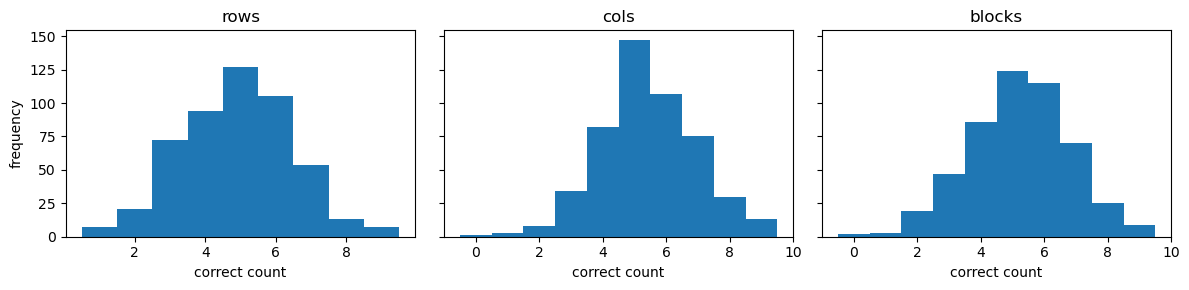

[4.902 5.416 5.214] [1.56728938 1.52412073 1.6025617 ]
5.177333333333333 1.579204300343126
[9 9 9] [1 0 0]
9.0


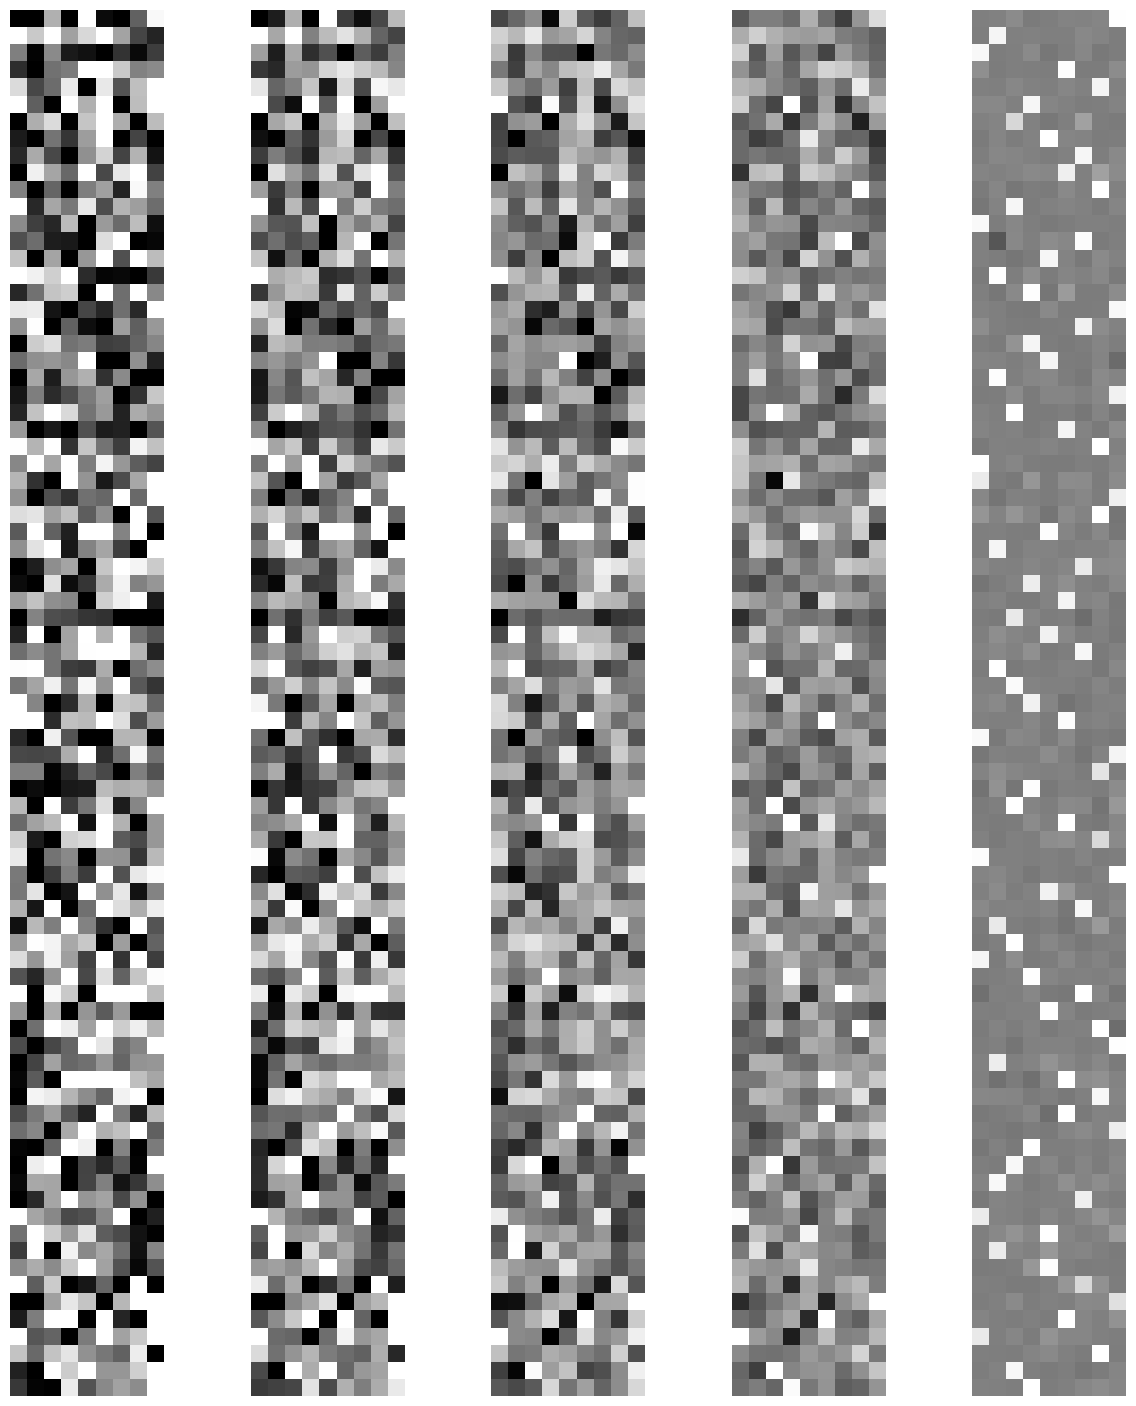

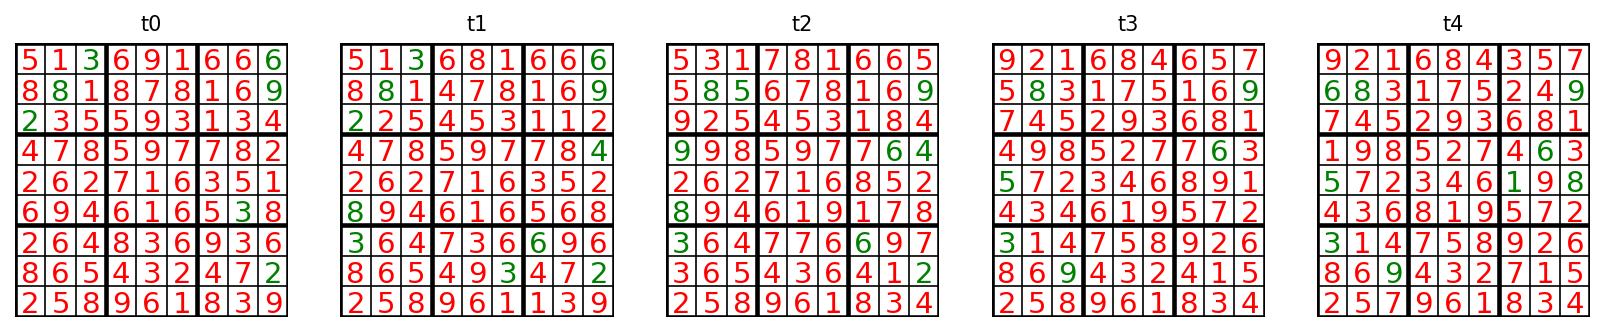

In [120]:
num_samples=500
num_timesteps = 200
num_marginals = 4


# Sample conditioning variable z
torch.cuda.manual_seed(1)
z, _ = path.sample_conditioning_variable(1) # (1,2)

# Construct integrator and plot trajectories
sigma = 0.4 # Can't make this too high or integration is numerically unstable!

sde = LangevinFlowSDE(flow_model, score_model, sigma)
simulator = EulerMaruyamaSimulator(sde)

x0, _ = path.p_simple.sample(num_samples) # (num_samples, 2)    
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1,1).expand(num_samples,-1,1,1).to(device) # (num_samples, nts, 1)

xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

solutions = xts[:, -1].argmax(dim=-1).cpu().numpy()

print(f"Valid sudokus:{np.sum([valid_sudoku81(sol+1) for sol in solutions])}/{len(solutions)}")

report = [sudoku81_report(sol+1) for sol in solutions]
report = np.array(report)

labels = ["rows", "cols", "blocks"]

fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for i in range(3):
    ax[i].hist(report[:, i], bins=np.arange(report[:, i].min(), report[:, i].max()+2)-0.5)
    ax[i].set_title(labels[i])
    ax[i].set_xlabel("correct count")
ax[0].set_ylabel("frequency")
plt.tight_layout()
plt.show()

print(np.mean(report, 0), np.std(report, 0))
print(np.mean(report), np.std(report))
print(np.max(report, 0), np.min(report, 0))
print(np.max(np.mean(report, -1)))
i = 0
if np.max(np.mean(report, -1)) == 9:
    i = np.argmax(np.mean(report, -1))

indexes = np.where(np.mean(report, -1) == 9)

cells_history = []
# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)

xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)

fig, axes = plt.subplots(1, xts_every_n.shape[1], figsize=(num_cols * xts_every_n.shape[1], 6 * num_rows))

for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = xts_every_n[i, plot_idx]
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[plot_idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[plot_idx].axis("off")

    cells_history.append(xt.argmax(axis=-1).to("cpu").numpy()+1)
plt.show()
gt = z[0].argmax(dim=-1).cpu().numpy()+1     # (81,)
draw_sudoku_path(cells_history, gt=gt, titles=[f"t{i}" for i in range(len(cells_history))])

In [140]:
num_gif_frames = 40
resize_factor = 5
title_text = "Sudoku ODE generation"
fps = 10

font = ImageFont.load_default()

gif_frames = np.linspace(0, num_timesteps - 1, num_gif_frames, dtype=int)
gif_images = []

# Layout knobs (tune these if you want)
SIDE_PAD = 100
HEADER_H = 80
FOOTER_H = 120
BG = (255, 255, 255)
FG = (0, 0, 0)

for k, t_idx in enumerate(gif_frames):
    xt = xts[i, t_idx]

    # ---- make the "imshow" image for this timestep ----
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1, 1))
    img = grid.permute(1, 2, 0).detach().cpu().numpy()
    img = ((img - img.min()) / (img.max() - img.min() + 1e-8) * 255).astype(np.uint8)

    pil_img = Image.fromarray(img)
    w, h = pil_img.size
    pil_img = pil_img.resize((w * resize_factor, h * resize_factor), resample=Image.NEAREST).convert("RGB")

    # ---- compute report + time ----
    cells = (xt.argmax(dim=-1).detach().cpu().numpy() + 1).reshape(-1)  # length 81
    rows, cols, blks = sudoku81_report(cells)

    t = float(t_idx) / float(num_timesteps - 1) if num_timesteps > 1 else 0.0

    # ---- Create canvas FIRST, then paste image into the body area ----
    canvas_w = pil_img.width + 2 * SIDE_PAD
    canvas_h = HEADER_H + pil_img.height + FOOTER_H

    frame = Image.new("RGB", (canvas_w, canvas_h), BG)
    draw = ImageDraw.Draw(frame)

    # paste the image centered in the body area
    body_x0 = SIDE_PAD
    body_y0 = HEADER_H
    frame.paste(pil_img, (body_x0, body_y0))

    # ---- Header: title ----
    title_bbox = draw.textbbox((0, 0), title_text, font=font)
    title_w = title_bbox[2] - title_bbox[0]
    title_h = title_bbox[3] - title_bbox[1]
    draw.text(((canvas_w - title_w) // 2, (HEADER_H - title_h) // 2), title_text, fill=FG, font=font)

    # ---- Footer: progress bar + time + stats ----
    footer_top = HEADER_H + pil_img.height

    # progress bar
    bar_margin_x = 40
    bar_w = canvas_w - 2 * bar_margin_x
    bar_h = 12
    bar_x0 = bar_margin_x
    bar_y0 = footer_top + 18

    draw.rectangle([bar_x0, bar_y0, bar_x0 + bar_w, bar_y0 + bar_h], outline=FG, width=2)
    fill_w = int(bar_w * max(0.0, min(1.0, t)))
    if fill_w > 0:
        draw.rectangle([bar_x0, bar_y0, bar_x0 + fill_w, bar_y0 + bar_h], fill=FG)

    time_text = f"t = {t:.3f}   frame {k+1}/{len(gif_frames)}"
    draw.text((bar_x0, bar_y0 + bar_h + 10), time_text, fill=FG, font=font)

    stats_text = f"rows: {rows}/9   cols: {cols}/9   blocks: {blks}/9"
    stats_bbox = draw.textbbox((0, 0), stats_text, font=font)
    stats_w = stats_bbox[2] - stats_bbox[0]
    draw.text(((canvas_w - stats_w) // 2, footer_top + 70), stats_text, fill=FG, font=font)

    gif_images.append(np.array(frame))

out_path = "sudoku_trajectory_SDE_fancy2.gif"
imageio.mimsave(out_path, gif_images, fps=fps)
print(f"Saved {out_path}")

Saved sudoku_trajectory_SDE_fancy2.gif


In [138]:
#torch.save(flow_model.state_dict(), "flow_model_128_square_time_tmp.pt")
#torch.save(score_model.state_dict(), "score_model_128_square_time_tmp.pt")

# Corrected SDE with "zero" vector field

In [122]:
class LangevinFlowSDE(SDE):
    def __init__(
        self, 
        flow_model: MLPVectorField, 
        score_model: MLPVectorField, 
        path : ConditionalProbabilityPath,
        sigma: float
    ):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, dim)
        """
        super().__init__()
        self.flow_model = flow_model
        self.score_model = score_model
        self.sigma = sigma

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        t = t.reshape(t.shape[0], -1)
        return self.flow_model(x,t) + 0.5 * self.sigma ** 2 * self.score_model(x, t)

    def drift_coefficient_with_sigma(self, x: torch.Tensor, t: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        t = t.reshape(t.shape[0], -1)
        sigma_shape = (self.path.beta.shape[0], 1, 1)
        sigma = torch.sqrt(2*self.path.beta*self.path.beta.dt - 2*((self.path.beta)**2)*self.path.alpha.dt/(self.path.alpha) )
        sigma = torch.sqrt(2*self.path.beta*self.path.beta.dt)
        sigma = sigma.reshape(sigma_shape)
        return 0.5 * sigma ** 2 * self.score_model(x, t)

    def diffusion_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        return self.sigma * torch.randn_like(x)

100%|█████████████████████████████████████████| 399/399 [02:28<00:00,  2.68it/s]


Valid sudokus:2/500


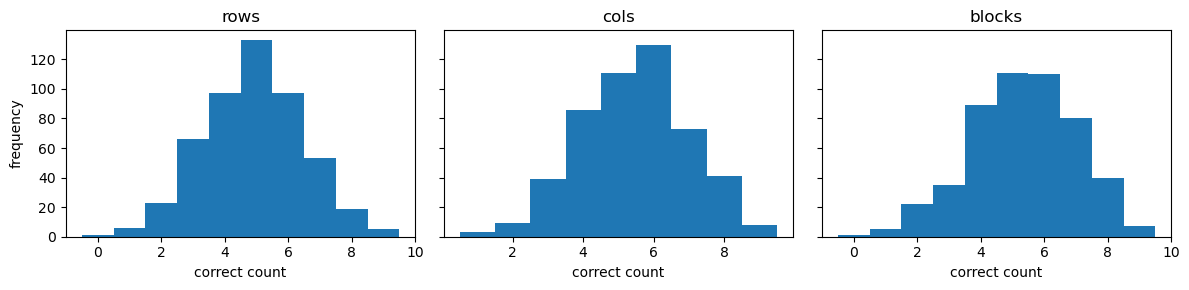

[4.906 5.456 5.336] [1.57770846 1.54015064 1.6598506 ]
5.232666666666667 1.610755378351688
[9 9 9] [0 1 0]
9.0


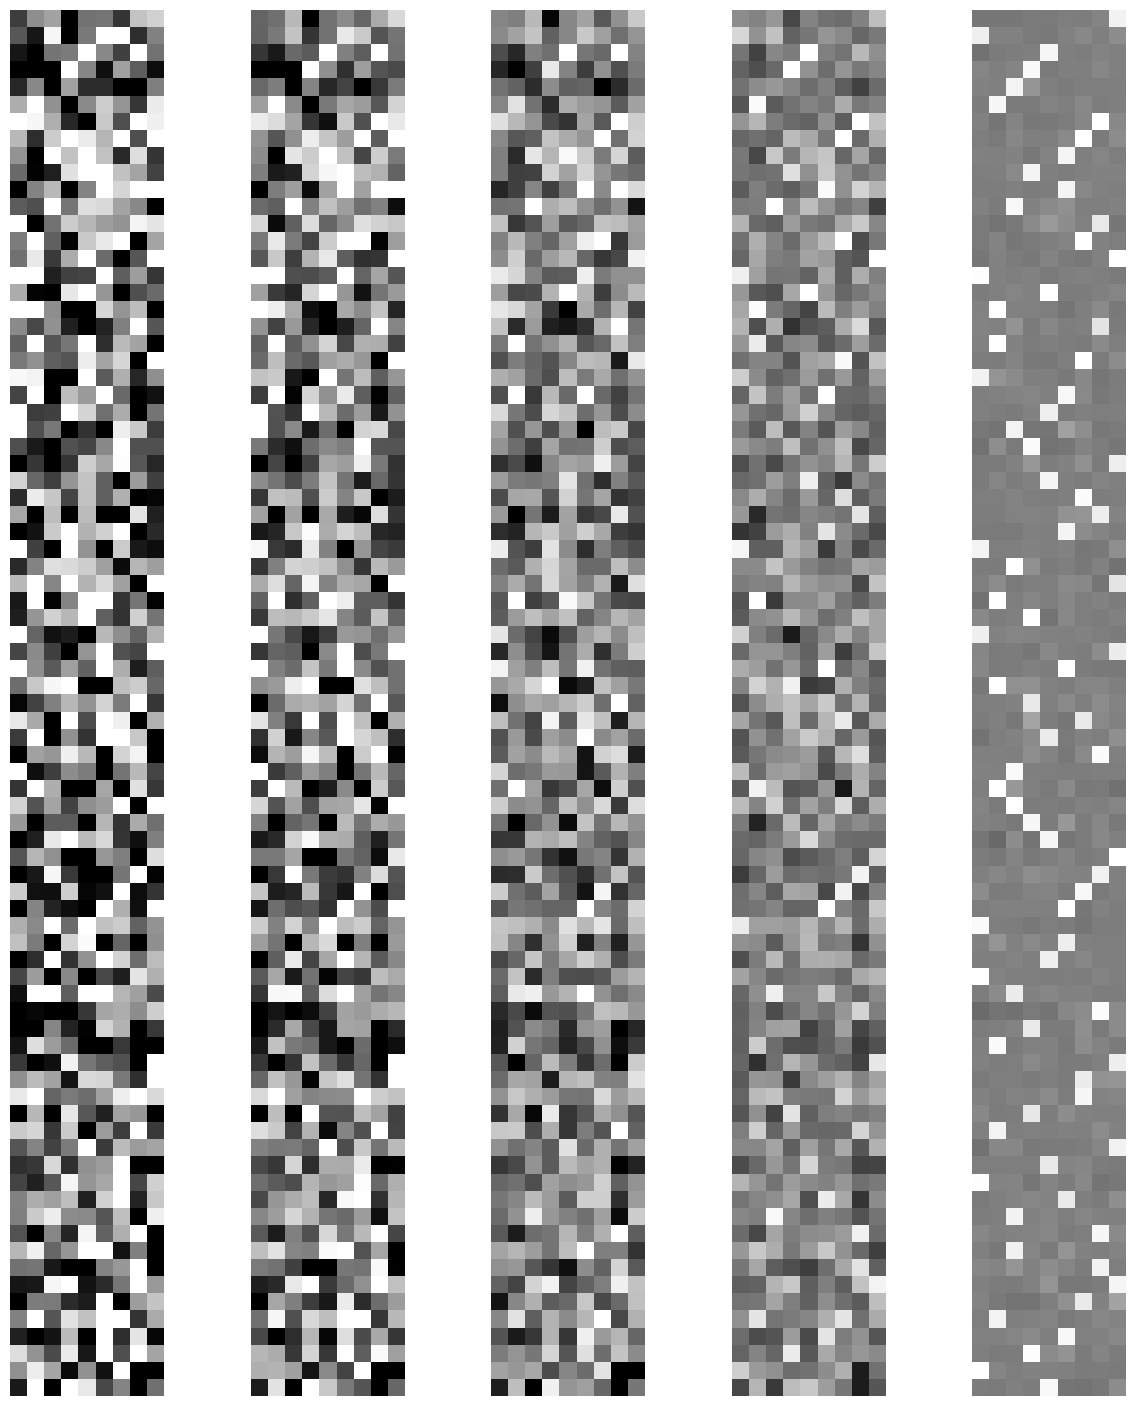

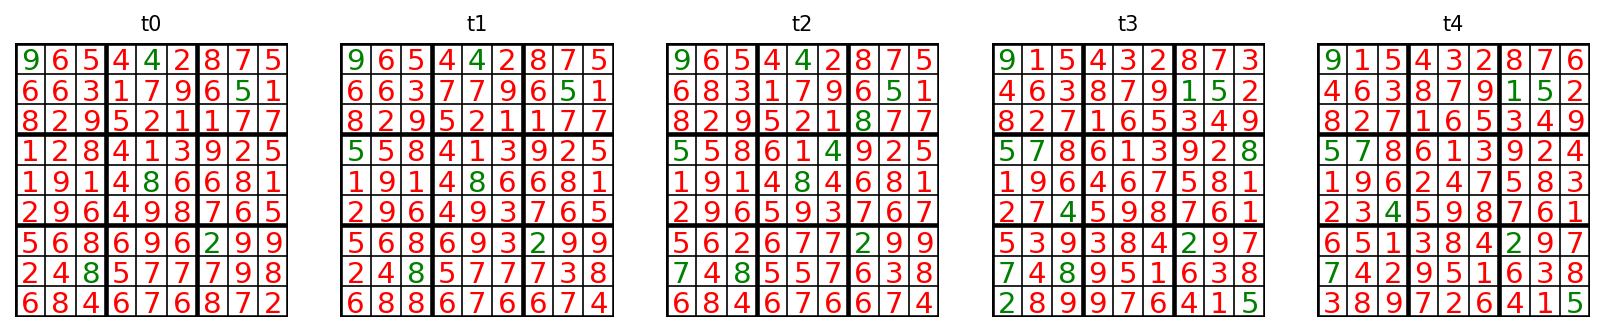

In [129]:
num_samples=500
num_timesteps = 400
num_marginals = 4


# Sample conditioning variable z
torch.cuda.manual_seed(1)
z, _ = path.sample_conditioning_variable(1) # (1,2)

# Construct integrator and plot trajectories
sigma = 0.4 # Can't make this too high or integration is numerically unstable!

sde = LangevinFlowSDE(flow_model, score_model, path, sigma)
simulator = EulerMaruyamaSimulator(sde)

x0, _ = path.p_simple.sample(num_samples) # (num_samples, 2)    
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1,1).expand(num_samples,-1,1,1).to(device) # (num_samples, nts, 1)

xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

solutions = xts[:, -1].argmax(dim=-1).cpu().numpy()

print(f"Valid sudokus:{np.sum([valid_sudoku81(sol+1) for sol in solutions])}/{len(solutions)}")

report = [sudoku81_report(sol+1) for sol in solutions]
report = np.array(report)

labels = ["rows", "cols", "blocks"]

fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for i in range(3):
    ax[i].hist(report[:, i], bins=np.arange(report[:, i].min(), report[:, i].max()+2)-0.5)
    ax[i].set_title(labels[i])
    ax[i].set_xlabel("correct count")
ax[0].set_ylabel("frequency")
plt.tight_layout()
plt.show()


print(np.mean(report, 0), np.std(report, 0))
print(np.mean(report), np.std(report))
print(np.max(report, 0), np.min(report, 0))
print(np.max(np.mean(report, -1)))
i = 0
if np.max(np.mean(report, -1)) == 9:
    i = np.argmax(np.mean(report, -1))

indexes = np.where(np.mean(report, -1) == 9)

cells_history = []
# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)

xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)

fig, axes = plt.subplots(1, xts_every_n.shape[1], figsize=(num_cols * xts_every_n.shape[1], 6 * num_rows))

for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = xts_every_n[i, plot_idx]
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[plot_idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[plot_idx].axis("off")

    cells_history.append(xt.argmax(axis=-1).to("cpu").numpy()+1)
plt.show()
gt = z[0].argmax(dim=-1).cpu().numpy()+1     # (81,)
draw_sudoku_path(cells_history, gt=gt, titles=[f"t{i}" for i in range(len(cells_history))])